In [1]:
from mapper_clusterer import *
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn.ensemble import IsolationForest
import pickle
import kmapper as km
from sklearn.preprocessing import OrdinalEncoder

In [2]:
from geography_helper import import_GA_boundary_file, places_to_geom
import geopandas as gpd
GA = import_GA_boundary_file('GAboundary.txt')
GApd = gpd.GeoDataFrame(data = pd.DataFrame({'state':['GA']}), geometry = [GA])

In [3]:
from anomaly_analyzer import AnomalyAnalyzer
from data_cluster_bundle import DataClusterBundle
from matplotlib import pyplot as plt
import matplotlib.ticker as mticker
from matplotlib import colors, cm
import seaborn as sns
from sklearn.cluster import KMeans

In [4]:
def feature_grapher(features, dims, data = None, c = 'maroon', alpha = .2):
        if len(dims) != 3:
            raise ValueError("Please pass exactly 3 indices")
            
        colnames = list(features.columns)

        x = features.iloc[:, dims[0]-1]
        y = features.iloc[:, dims[1]-1]
        z = features.iloc[:, dims[2]-1]

        fig = plt.figure(figsize=(12,10))
        ax = fig.add_subplot(111, projection="3d")
        ax.scatter(x,y,z, c=c, marker="o",alpha=alpha)
        ax.set_title(f"Projection to dimensions {dims}")

        ax.set_xlabel(colnames[dims[0]-1])
        ax.set_ylabel(colnames[dims[1]-1])
        ax.set_zlabel(colnames[dims[2]-1])
        
        plt.show()

Number of observations with no imputed data

In [5]:
features = pd.read_csv('combined_features.csv', index_col = 0)
nonull = features.loc[features.isna().sum(axis = 1) == 0,:].shape[0]
print(f'1% of {nonull} is {0.01*nonull} houses')

1% of 10774 is 107.74000000000001 houses


In [6]:
features.shape[0]

13086

On zillow.com, there were about 2k houses for sale in all of atlanta. If there were 5 classes of houses only, the highest area would have 400 listings. If there are 10, only 200.

In [7]:
pca_features = pd.read_csv('pca_features_fixed.csv', index_col = 0)
coords = pca_features[['latitude', 'longitude']].values
X = pca_features.drop(['latitude', 'longitude'], axis = 1)
X_5 = X.iloc[:,:5]
pca_coord = pd.concat([pd.DataFrame({'latitude': coords[:,0], 'longitude': coords[:,1]}), X_5], axis =1)

In [8]:
features = pd.read_csv('combined_features.csv', index_col = 0)

In [9]:
kmeans = KMeans(n_clusters = 3, random_state = 7)
major_groups = np.array(kmeans.fit_predict(X_5))
major_clusters = pd.concat([pca_coord,pd.Series(major_groups,name = 'major_cluster')],axis = 1)
triple = colors.ListedColormap(cm.Set1([1,2,3]))
group_colors = cm.Set1(major_groups + 1)

In [10]:
def plot_anomaly_comparison(aanalyz, axis, title):
    GApd.plot(ax =axis, alpha = .5) #background
    #All listings in grey
    places_to_geom(features).plot(ax = axis, markersize = 20, color = 'grey', alpha = .2, label = 'All listings')
    #High PC5 Areas
    places_to_geom(pca_coord[pca_coord.PC5 > 2]).plot(ax = axis, label = 'High PC5', 
                                                    markersize = 50, color = 'orange')
    #Urban (cluster 1) areas
    places_to_geom(major_clusters[major_clusters.major_cluster == 1]).plot(ax = axis, color = triple(1), 
                                            legend = True, label = 'Cluster 1 (Urban)', markersize = 25)

    #Anomalies 
    places_to_geom(aanalyz.anomalies).plot(ax = axis, markersize = 20, color = 'blue', alpha = .5, 
                                           label = 'anomalies')

    #Reorder legend
    handles, labels = plt.gca().get_legend_handles_labels()
    order = [3,2,1,0]
    leg = axis.legend([handles[i] for i in order], [labels[i] for i in order], fontsize = 16)
    #Set alpha values for legend to full for all artists
    for lh in leg.legendHandles: 
        lh.set_alpha(1)

    axis.axis('off') # no axes
    #Set title
    axis.set_title(title, fontsize = 28)

# Testing local AC tuning

## Plot local partitions

In [11]:
covercoords = np.concatenate((np.arange(len(coords)).reshape(-1,1), coords), axis =1)

In [12]:
U = km.Cover(n_cubes=20, perc_overlap = .08)
blocks = U.fit(covercoords)
U.radius_

array([0.12583948, 0.12690573])

(-85.84627525, -80.54184975, 30.1234797, 35.2335803)

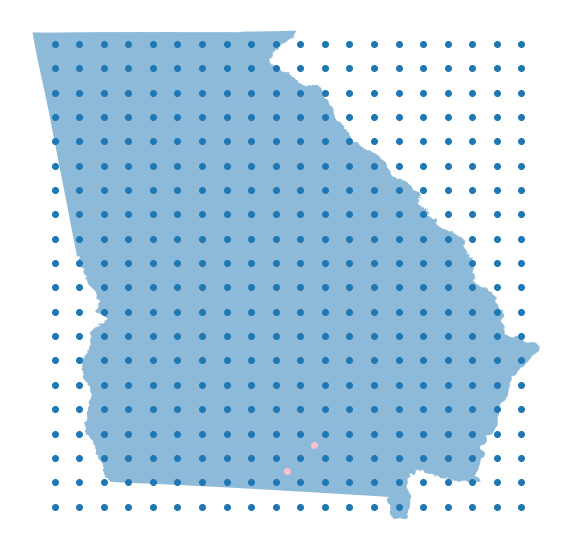

In [13]:
fig,ax = plt.subplots(figsize = (10,10))
GApd.plot(ax =ax, alpha = .5)
places_to_geom(pd.DataFrame(np.array(blocks)).rename({0:'latitude', 1:'longitude'}, axis = 1)).plot(ax =ax)
places_to_geom(pd.DataFrame(np.array([blocks[50]+U.radius_, blocks[50] - U.radius_])).rename({0:'latitude', 1:'longitude'}, axis = 1)).plot(ax=ax, color = 'pink')
plt.axis('off')

## Low thresh, higher overlap

In [14]:
low_high = ClusterOverCoords(X_5, coords, AgglomerativeClustering(n_clusters = None, distance_threshold = 2.6), 
                       cover = km.Cover(n_cubes = 20, perc_overlap = .11))

In [15]:
low_high.generate_clusters()

100%|█████████████████████████████████████████████| 13086/13086 [00:05<00:00, 2472.11it/s]


In [16]:
# with open('ac_point01_cubes10_perc10_fixed_pca.pickle', 'wb') as f:
#     pickle.dump(ac_point1, f)

In [17]:
# with open('ac_point05_fixed_pca.pickle', 'rb') as f:
#     ac_point05 = pickle.load(f)

In [18]:
print(f'Total clusters: {np.unique(low_high.components).shape[0]}')

Total clusters: 1107


cluster_label  n_members
0             68        919
1            280        726
2             82        602
3            338        521
4             73        472
5             63        253
6            167        168
7             62        131
8            191        120
9            506         94

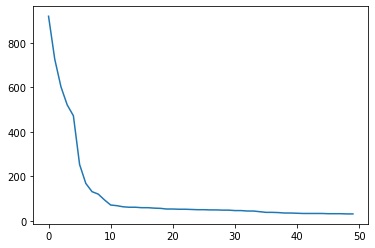

In [19]:
labeled_lh = low_high.data_with_labels()
sizes_lh = low_high.get_cluster_sizes()
sizes_lh.head(50).n_members.plot()
sizes_lh.head(10)

<AxesSubplot:>

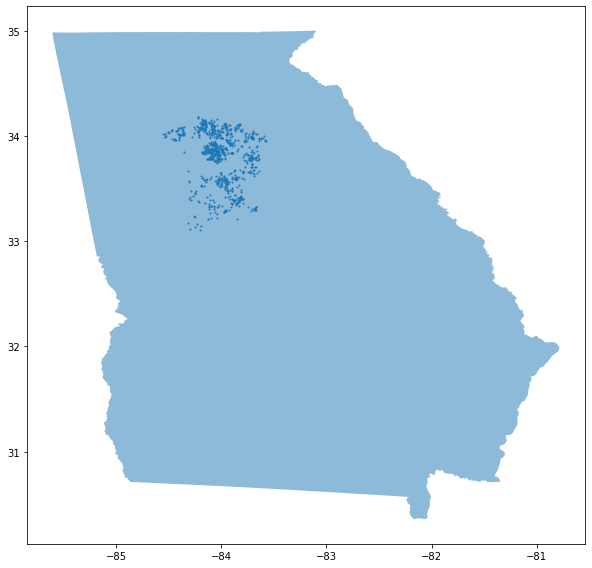

In [20]:
nth_largest = 0

fig, ax = plt.subplots(figsize = (10,10))
GApd.plot(ax = ax, alpha = .5)
places_to_geom(labeled_lh[labeled_lh['cluster'] == sizes_lh.iloc[nth_largest, 0]]).plot(ax = ax, markersize = 1)

<AxesSubplot:>

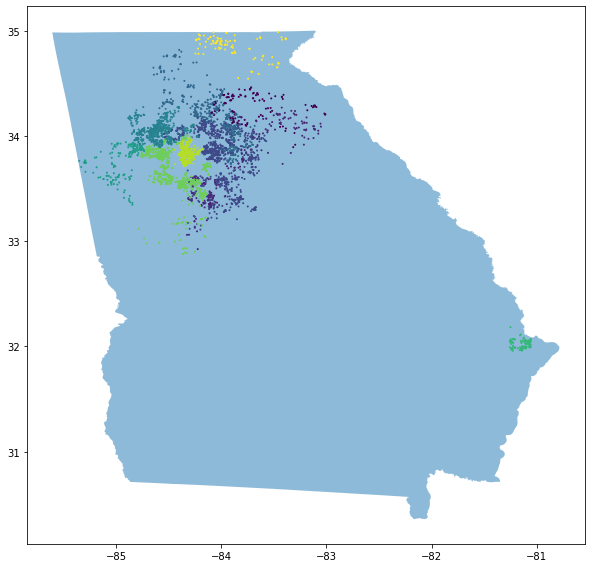

In [21]:
in_top_n = labeled_lh[labeled_lh['cluster'].isin(sizes_lh.iloc[:10, 0])]



fig, ax = plt.subplots(figsize = (10,10))
GApd.plot(ax = ax, alpha = .5)
places_to_geom(in_top_n).plot(ax = ax, markersize = 1, 
                              c = OrdinalEncoder().fit_transform(in_top_n.cluster.values.reshape(-1,1)).reshape(-1))
    

In [22]:
aa_lh = AnomalyAnalyzer(low_high, features)

There are 130 anomalies with no imputed values.


(-85.84627525, -80.54184975, 30.1234797, 35.2335803)

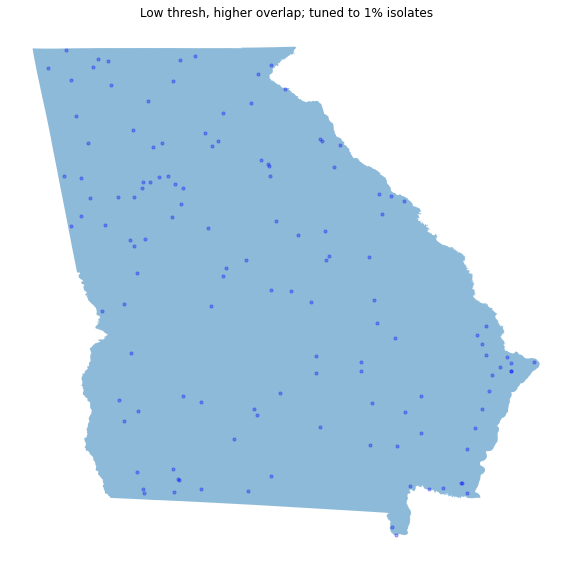

In [23]:
aa_lh.get_all_anomalies(1,1, drop_imputed = True)
print(f'There are {aa_lh.anomalies.shape[0]} anomalies with no imputed values.')

fig,ax = plt.subplots(figsize = (10,10))
GApd.plot(ax =ax, alpha = .5)
places_to_geom(aa_lh.anomalies).plot(ax = ax, markersize = 10, color = 'blue', alpha = .3)
plt.title('Low thresh, higher overlap; tuned to 1% isolates')
plt.axis('off')

## High Thresh, lower overlap

In [24]:
high_low = ClusterOverCoords(X_5, coords, AgglomerativeClustering(n_clusters = None, distance_threshold = 2.9), 
                       cover = km.Cover(n_cubes = 20, perc_overlap = .065))

In [25]:
high_low.generate_clusters()

100%|█████████████████████████████████████████████| 13086/13086 [00:04<00:00, 3096.25it/s]


In [26]:
# with open('ac_point01_cubes10_perc10_fixed_pca.pickle', 'wb') as f:
#     pickle.dump(ac_point1, f)

In [27]:
# with open('ac_point05_fixed_pca.pickle', 'rb') as f:
#     ac_point05 = pickle.load(f)

In [28]:
print(f'Total clusters: {np.unique(high_low.components).shape[0]}')

Total clusters: 1132


In [29]:
labeled_hl = high_low.data_with_labels()
sizes_hl = high_low.get_cluster_sizes()
sizes_hl.head()

cluster_label  n_members
0             71        515
1             80        321
2            302        285
3            298        219
4            174        182

<AxesSubplot:>

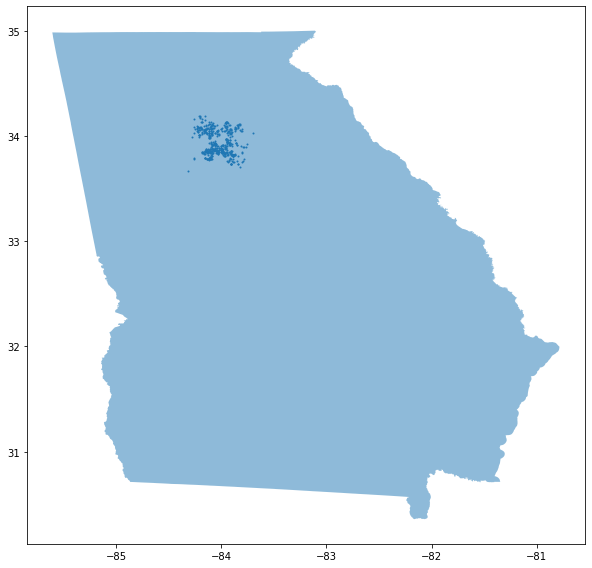

In [30]:
nth_largest = 0

fig, ax = plt.subplots(figsize = (10,10))
GApd.plot(ax = ax, alpha = .5)
places_to_geom(labeled_hl[labeled_hl['cluster'] == sizes_hl.iloc[nth_largest, 0]]).plot(ax = ax, markersize = 1)

In [31]:
aa_hl = AnomalyAnalyzer(high_low, features)

There are 129 anomalies with no imputed values.


(-85.84627525, -80.54184975, 30.1234797, 35.2335803)

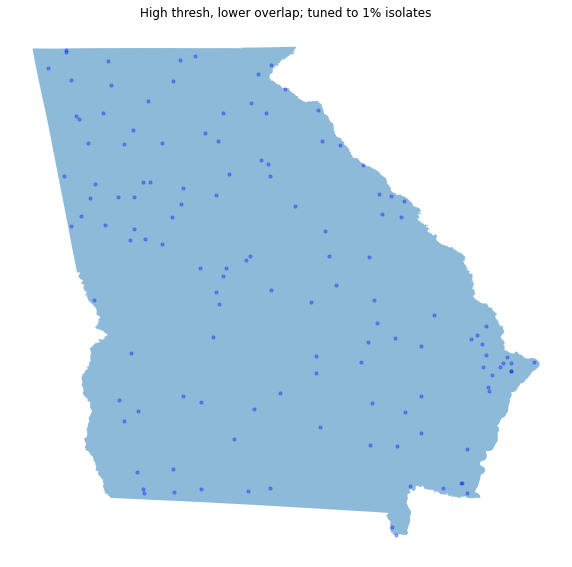

In [32]:
aa_hl.get_all_anomalies(1,1, drop_imputed = True)
print(f'There are {aa_hl.anomalies.shape[0]} anomalies with no imputed values.')

fig,ax = plt.subplots(figsize = (10,10))
GApd.plot(ax =ax, alpha = .5)
places_to_geom(aa_hl.anomalies).plot(ax = ax, markersize = 10, color = 'blue', alpha = .3)
plt.title('High thresh, lower overlap; tuned to 1% isolates')
plt.axis('off')

# Local AC

Nice settings:
thresh 6, 20 cubes, 1% overlap
641 clusters
top 10 range from 126-244 listings
But at lower thresholds does avoid city property

thresh 1, 20 cubes, 1% overlap
high number of clusters, but number are reasonable (how many similar listings do you expect in one area?)
At limit of 1 similar house, covers 1300, a little more than 5% of what could have been marked as anomalous

thresh 2, 20 cubes, 1% overlap
high number of clusters, but number are reasonable (how many listings with SIMILAR PROPERTIES do you expect in one area, the highest being around 46 listings)
At limit of 1 similar house, covers 329, a little more than 3% of what could have been marked as anomalous

at both of the levels above, there is appropriate anomaly spread throughout the map

at thresh 3, 20 cubes, 1% overlap
has high of 90 listings in a group
140, close to 1% are isolates; however, at this level, not all but some city properties vanish
391, about 3%, are isolates or have at most 1 similar. this already has wide geographic spread

probably don't want to go lower than 3 or isolates will become biased against city, unless we lower the perc_overlap

at 2.5, 6% overlap, and 20 cubes, nice situation in that still many city area anomalies detected within 1.7%. Keeping the overlap the same, thresh of 3 tunes to 1% outliers

Similar with 2.6, 8% overlap, 20 cubes. Nice situation, some city area anomalies within 1.5% anomaly rate
distribution also looks realistic. most common class is 634 (probably 624 like it in the area), and the top 20 all stay above 50 members and account for a third of the houses. still avoids city somewhat, but within 3.6% there are clearly many anomalies in both urban and rural areas
Moreover, as the cluster size cutoff is changed, it adds anomalies much more evenly across the map

Tuning to get around 100 isolates (about 1% of possible outliers) seems to product good results. Ex: thresh 3, 20 cubes, 7.6% overlap

we get about 5% at 1.45 thresh and .076 overlap 

In [33]:
ac_thresh2p6_cubes20_overlap8 = ClusterOverCoords(X_5, coords, AgglomerativeClustering(n_clusters = None, distance_threshold = 2.6), 
                       cover = km.Cover(n_cubes = 20, perc_overlap = .08))

In [34]:
ac_thresh2p6_cubes20_overlap8.generate_clusters()

100%|█████████████████████████████████████████████| 13086/13086 [00:04<00:00, 2701.12it/s]


In [35]:
# with open('ac_thresh2p6_cubes20_overlap8.pickle', 'wb') as f:
#     pickle.dump(ac_thresh2p6_cubes20_overlap8, f)

In [36]:
# with open('ac_point05_fixed_pca.pickle', 'rb') as f:
#     ac_point05 = pickle.load(f)

In [37]:
print(f'Total clusters: {np.unique(ac_thresh2p6_cubes20_overlap8.components).shape[0]}')

Total clusters: 1248


In [38]:
labeled_thresh2p6_cubes20_overlap8 = ac_thresh2p6_cubes20_overlap8.data_with_labels()
sizes_thresh2p6_cubes20_overlap8 = ac_thresh2p6_cubes20_overlap8.get_cluster_sizes()
sizes_thresh2p6_cubes20_overlap8.head(10)

cluster_label  n_members
0            175        634
1            366        425
2             88        376
3            318        161
4             76        144
5             63        138
6            342        111
7            323        101
8             78         97
9            433         97

/var/folders/g3/v_62hrbj20d1z2xt6c246v780000gn/T/ipykernel_31040/689031568.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(xlabel = 'Rank of cluster by size', ylabel = 'Size of cluster (# of listings)',


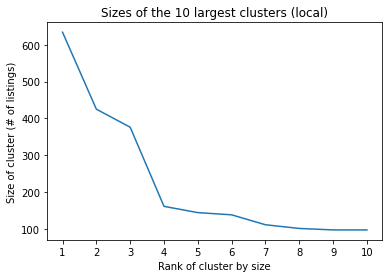

In [39]:
ticks = np.arange(10).tolist()

fig, ax = plt.subplots()
sizes_thresh2p6_cubes20_overlap8.n_members.head(10).plot(ax = ax)
ax.set_title('Sizes of the 10 largest clusters (local)', fontsize = 12)
ax.set(xlabel = 'Rank of cluster by size', ylabel = 'Size of cluster (# of listings)',
      xticklabels = [str(x) for x in np.arange(1,11)])
# ax.set_xticklabels()
ax.xaxis.set_major_locator(mticker.FixedLocator(ticks))
ax.set_xticklabels([str(x+1) for x in ticks])

fig.savefig('local_cluster_sizes.png', dpi = 320, bbox_inches = 'tight', pad_inches = .01)

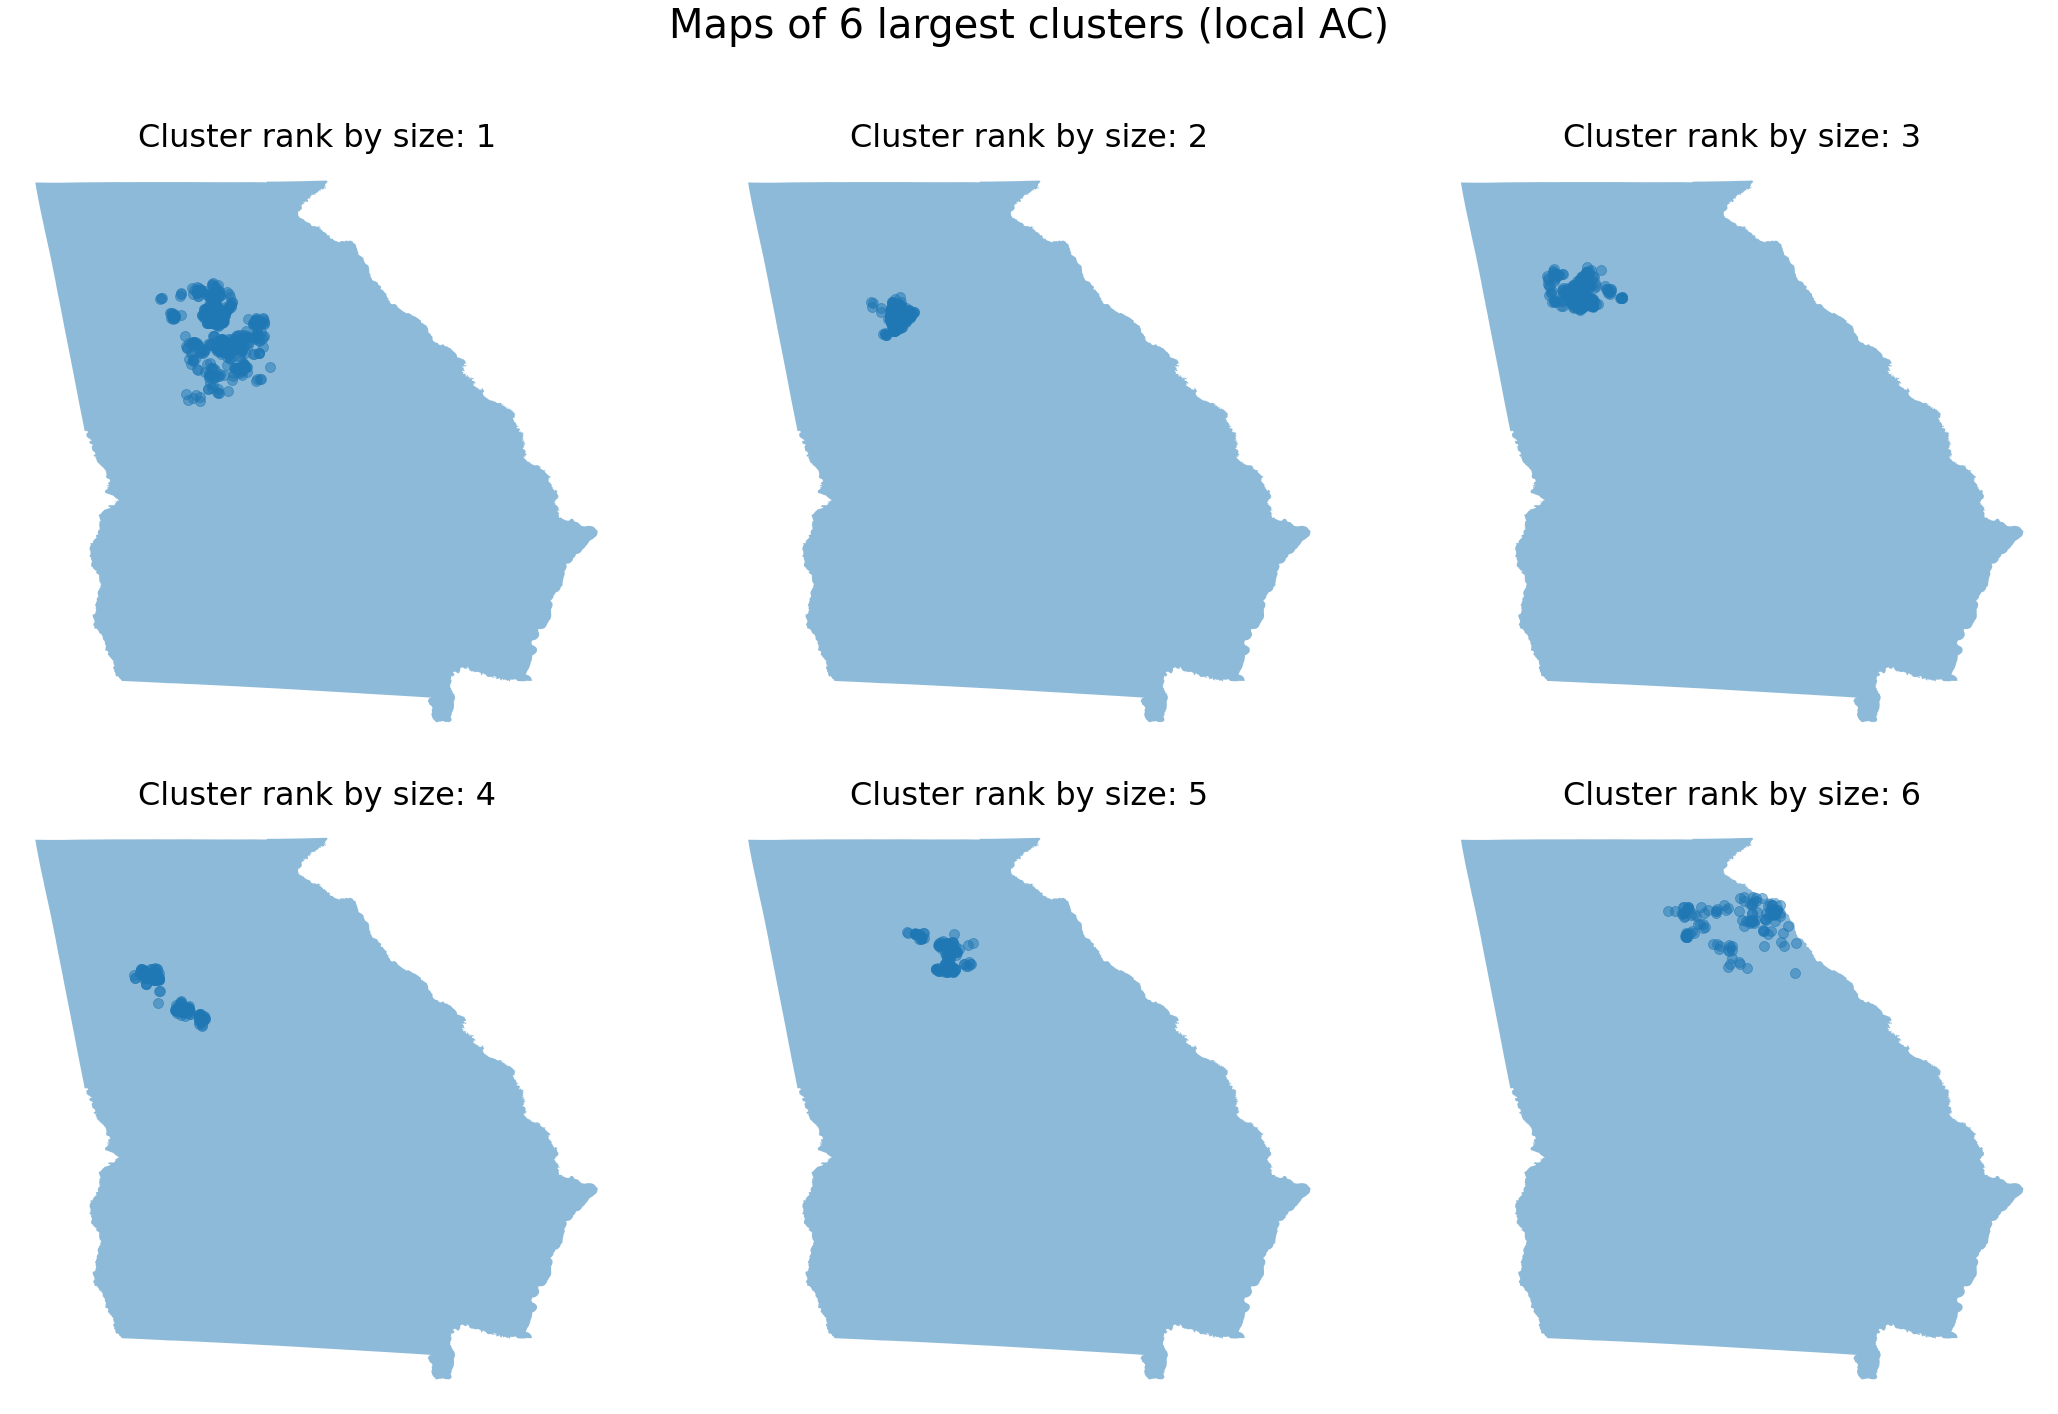

In [40]:
# nth_largest = 0

fig = plt.figure(figsize = (30,20))
axes = [fig.add_subplot(2,3,k+1) for k in range(6)]
for idx, axis in enumerate(axes):
    axis.axis('off')
    axis.set_title(f'Cluster rank by size: {idx+1}', fontsize = 32)
    GApd.plot(ax = axis, alpha = .5)
    places_to_geom(labeled_thresh2p6_cubes20_overlap8[labeled_thresh2p6_cubes20_overlap8['cluster'] == 
                                sizes_thresh2p6_cubes20_overlap8.iloc[idx, 0]]).plot(ax = axis, markersize = 100, alpha = .5)
fig.tight_layout(h_pad=5.0, w_pad = 0.0, rect=[0, 0, 1, 0.9])
fig.suptitle('Maps of 6 largest clusters (local AC)', fontsize = 40)
fig.savefig('largest_clusters_local.png', dpi = 320, bbox_inches = 'tight', pad_inches = .01)

<AxesSubplot:>

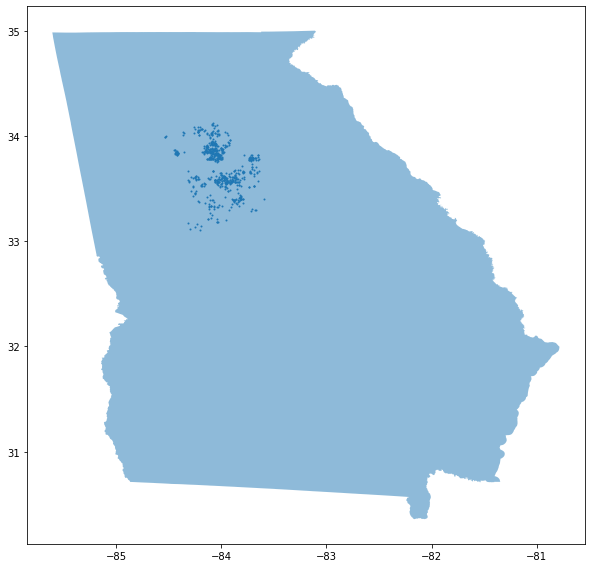

In [41]:
nth_largest = 0

fig, ax = plt.subplots(figsize = (10,10))
GApd.plot(ax = ax, alpha = .5)
places_to_geom(labeled_thresh2p6_cubes20_overlap8[labeled_thresh2p6_cubes20_overlap8['cluster'] 
                                                  == sizes_thresh2p6_cubes20_overlap8.iloc[nth_largest, 0]]).plot(ax = ax, markersize = 1)

In [42]:
aa_thresh2p6_cubes20_overlap8 = AnomalyAnalyzer(ac_thresh2p6_cubes20_overlap8, features)

There are 156 anomalies with no imputed values.


(-85.84627525, -80.54184975, 30.1234797, 35.2335803)

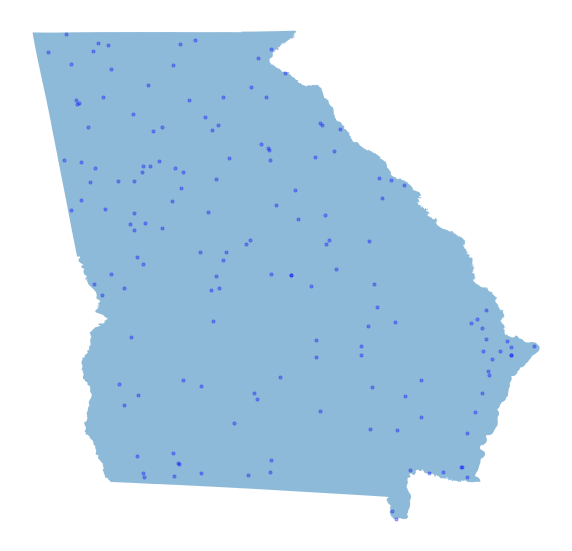

In [43]:
aa_thresh2p6_cubes20_overlap8.get_all_anomalies(1,1, drop_imputed = True)
print(f'There are {aa_thresh2p6_cubes20_overlap8.anomalies.shape[0]} anomalies with no imputed values.')

fig,ax = plt.subplots(figsize = (10,10))
GApd.plot(ax =ax, alpha = .5)
places_to_geom(aa_thresh2p6_cubes20_overlap8.anomalies).plot(ax = ax, markersize = 10, color = 'blue', alpha = .3)
plt.axis('off')

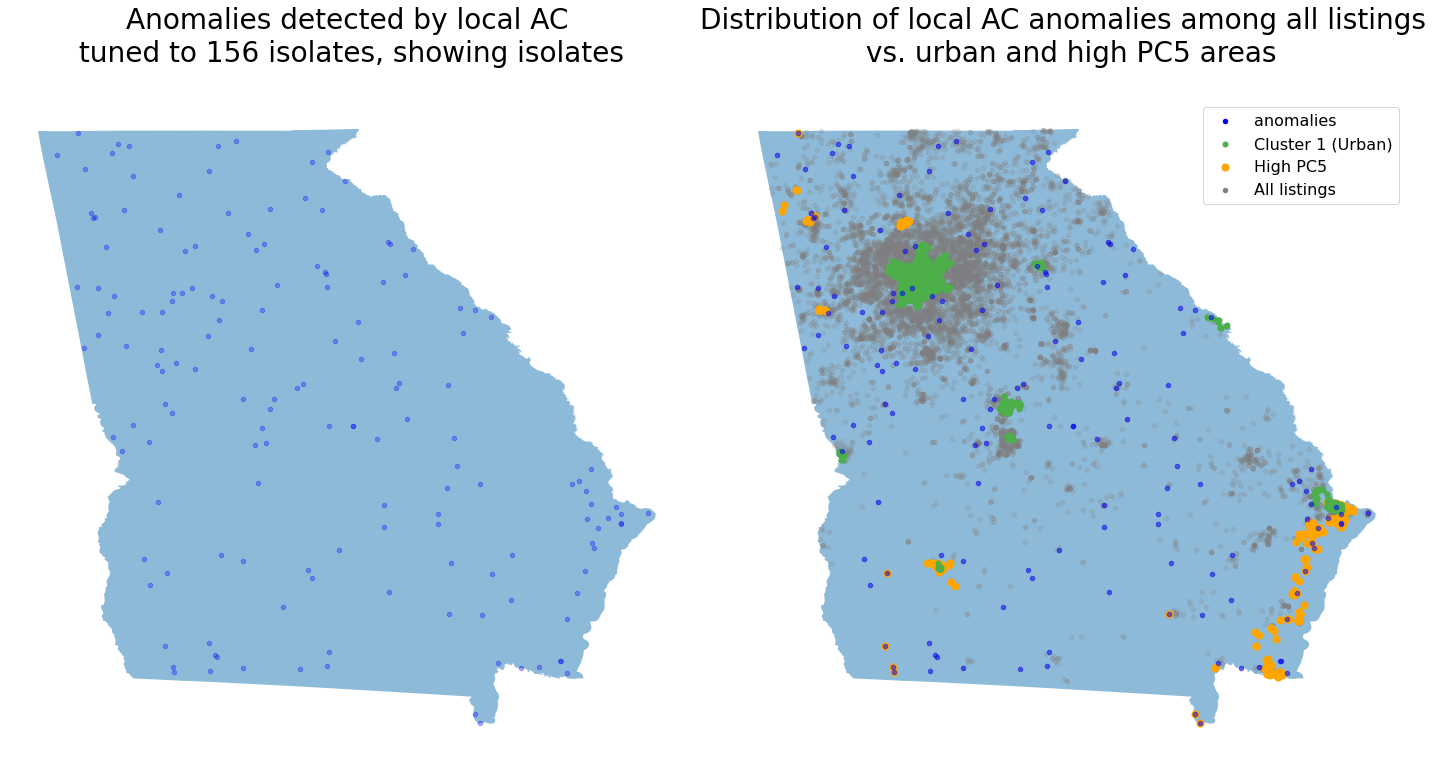

In [44]:
fig = plt.figure(figsize = (20,10))

ax1 = fig.add_subplot(121)
GApd.plot(ax =ax1, alpha = .5)
places_to_geom(aa_thresh2p6_cubes20_overlap8.anomalies).plot(ax = ax1, markersize = 20, color = 'blue', alpha = .3)
ax1.axis('off')
ax1.set_title('Anomalies detected by local AC\n tuned to 156 isolates, showing isolates\n', fontsize = 28)

ax2 = fig.add_subplot(122)
plot_anomaly_comparison(aa_thresh2p6_cubes20_overlap8, ax2,
                       'Distribution of local AC anomalies among all listings \n vs. urban and high PC5 areas\n')
fig.tight_layout(pad = 0)
fig.savefig('local_anomaly_map.png', dpi = 320, bbox_inches = 'tight', pad_inches = .01)

# Check against global

## No LL

At the low threshold of 1, 380 are isolated, but they are HIGHLY concentrated in the city.

Raising the threshold to 2 (lowering anomaly count), 171 are isolated, and even more strongly biased towards the city. Raising the threshold reveals only more anomalies in the same areas. Even at 12% anomaly rate, it is clearly just detecting urban features.



The pattern continues when raising to 3. 1% anomaly is almost exclusively in city. Even at 800 anomalies, it barely has the spread of the local version's 384. 

The problem worsens when threshold is raised is that despite starting with fewer anomalies, it is heavily biased: we can raise the cutoff even higher and stay isolated to the cities.

--- Now try lowering ---
Lowering to .75 already had 938 isolates, centered around cities. Even just lowering to .9. Spread is still centered around the city.

In [45]:
noLL = AgglomerativeClustering(n_clusters = None, distance_threshold = 1.28)
results_noLL = noLL.fit_predict(X_5)
print(f'Total clusters: {np.unique(results_noLL).shape[0]}')

Total clusters: 2547


In [46]:
dcb_noLL = DataClusterBundle(X_5, coords, results_noLL)
aa_noLL = AnomalyAnalyzer(dcb_noLL, features)

In [47]:
# with open('noLL.pickle', 'wb') as f:
#     pickle.dump(dcb_noLL, f)

In [48]:
labeled_noLL = dcb_noLL.data_with_labels()
sizes_noLL = dcb_noLL.get_cluster_sizes()
sizes_noLL

cluster_label  n_members
0              1862         32
1               789         23
2               212         21
3              1028         20
4               313         20
...             ...        ...
2542           2101          1
2543           1875          1
2544           2375          1
2545           1789          1
2546           1383          1

[2547 rows x 2 columns]

/var/folders/g3/v_62hrbj20d1z2xt6c246v780000gn/T/ipykernel_31040/255530957.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(xlabel = 'Rank of cluster by size', ylabel = 'Size of cluster (# of listings)',


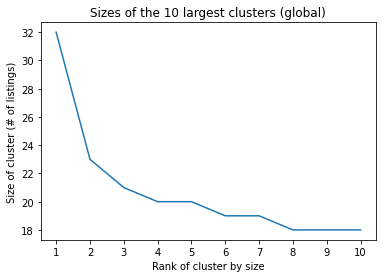

In [49]:
ticks = np.arange(10).tolist()

fig, ax = plt.subplots()
sizes_noLL.n_members.head(10).plot(ax = ax)
ax.set_title('Sizes of the 10 largest clusters (global)', fontsize = 12)
ax.set(xlabel = 'Rank of cluster by size', ylabel = 'Size of cluster (# of listings)',
      xticklabels = [str(x) for x in np.arange(1,11)])
# ax.set_xticklabels()
ax.xaxis.set_major_locator(mticker.FixedLocator(ticks))
ax.set_xticklabels([str(x+1) for x in ticks])

fig.savefig('global_cluster_sizes.png', dpi = 320, bbox_inches = 'tight', pad_inches = .01)

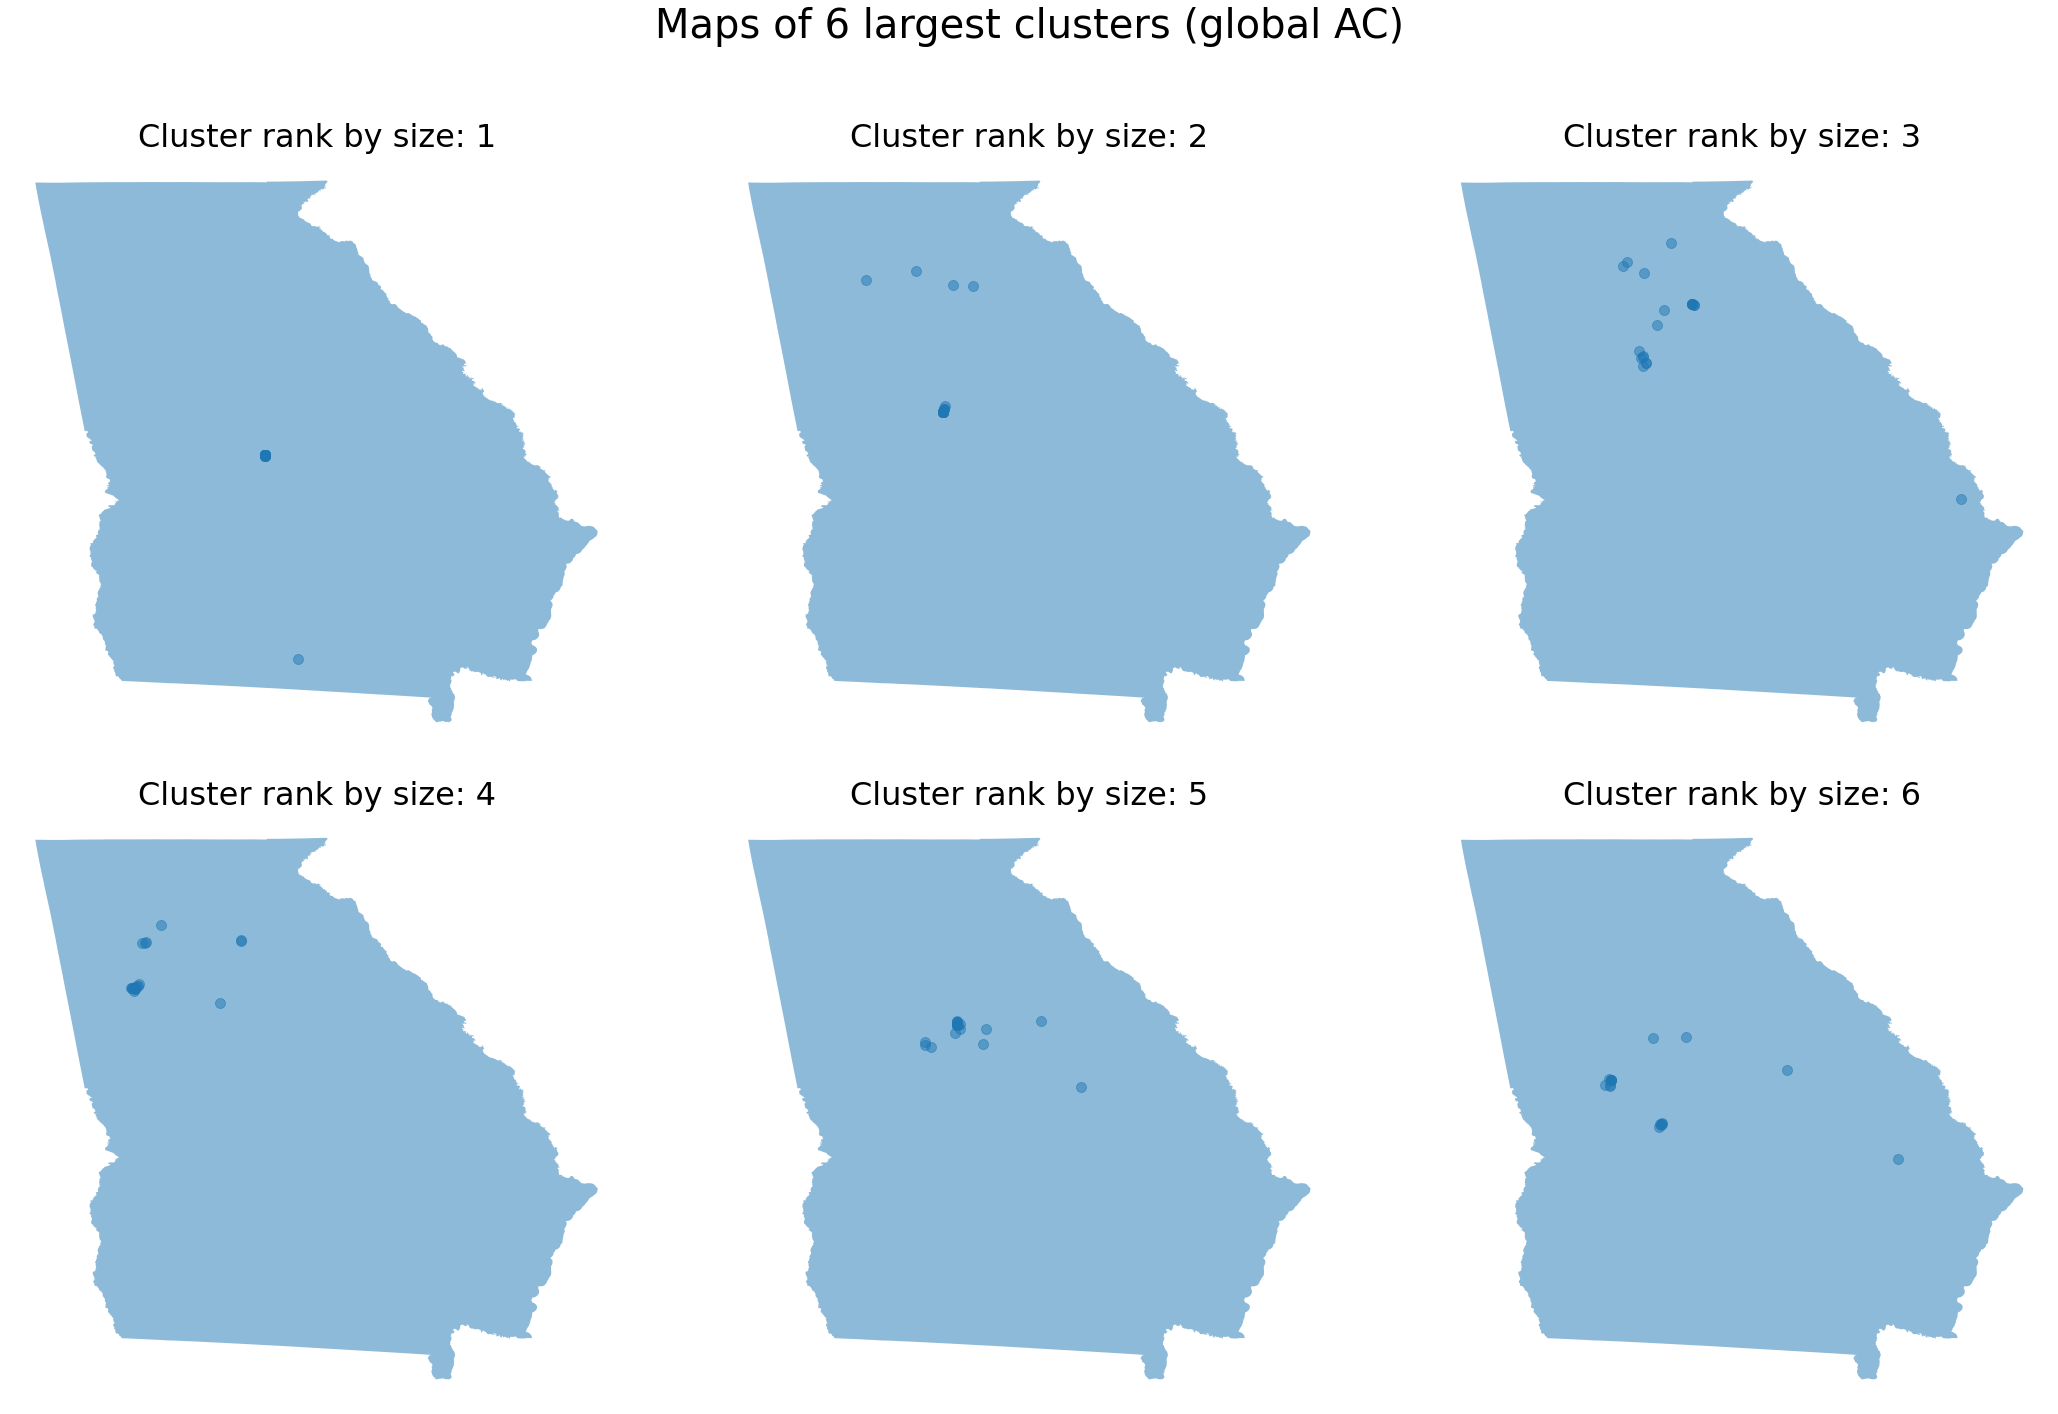

In [50]:
# nth_largest = 0

fig = plt.figure(figsize = (30,20))
axes = [fig.add_subplot(2,3,k+1) for k in range(6)]
for idx, axis in enumerate(axes):
    axis.axis('off')
    axis.set_title(f'Cluster rank by size: {idx+1}', fontsize = 32)
    GApd.plot(ax = axis, alpha = .5)
    places_to_geom(labeled_noLL[labeled_noLL['cluster'] == 
                                sizes_noLL.iloc[idx, 0]]).plot(ax = axis, markersize = 100, alpha = .5)
fig.tight_layout(h_pad=5.0, w_pad = 0.0, rect=[0, 0, 1, 0.9])
fig.suptitle('Maps of 6 largest clusters (global AC)', fontsize = 40)
fig.savefig('largest_clusters_global.png', dpi = 320, bbox_inches = 'tight', pad_inches = .01)

There are 154 anomalies with no imputed values.


Text(0.5, 1.0, 'Anomalies detected by global AC\n tuned to 154 isolates, showing isolates')

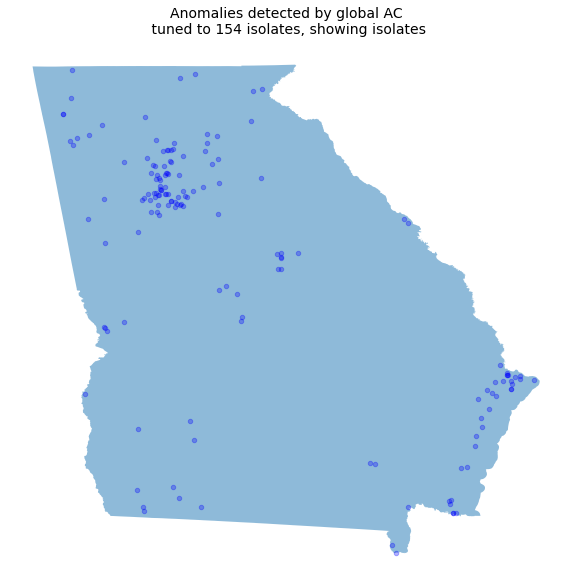

In [51]:
aa_noLL.get_all_anomalies(1,1, drop_imputed = True)
print(f'There are {aa_noLL.anomalies.shape[0]} anomalies with no imputed values.')

fig,ax = plt.subplots(figsize = (10,10))
GApd.plot(ax =ax, alpha = .5)
places_to_geom(aa_noLL.anomalies).plot(ax = ax, markersize = 20, color = 'blue', alpha = .3)
ax.axis('off')
ax.set_title('Anomalies detected by global AC\n tuned to 154 isolates, showing isolates', fontsize = 14)

<AxesSubplot:xlabel='PC5', ylabel='Proportion'>

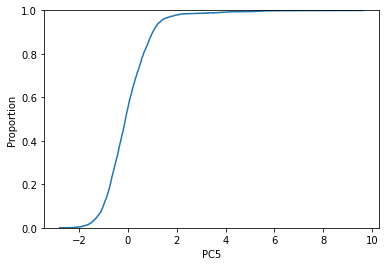

In [52]:
sns.ecdfplot(data = pca_coord.PC5)

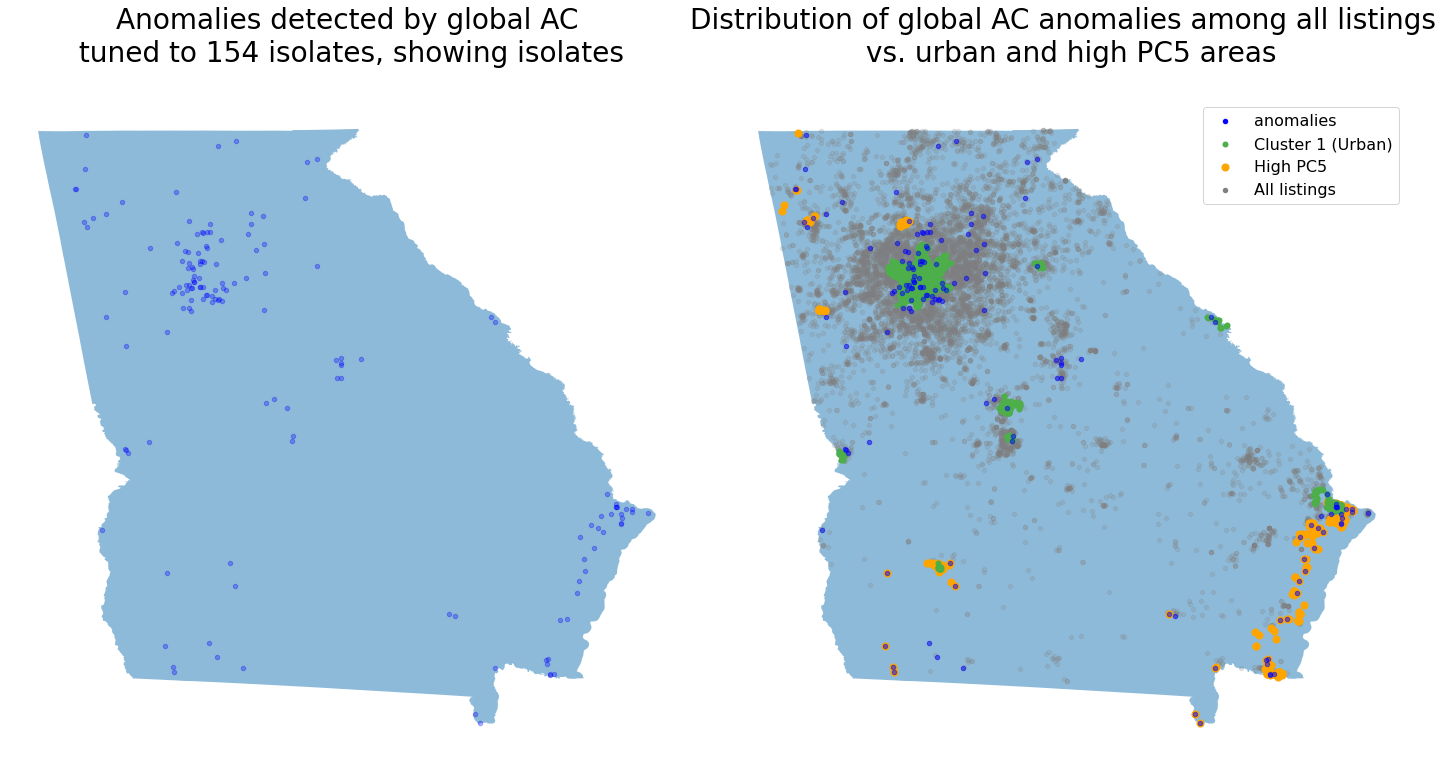

In [53]:
fig = plt.figure(figsize = (20,10))

ax1 = fig.add_subplot(121)
GApd.plot(ax =ax1, alpha = .5)
places_to_geom(aa_noLL.anomalies).plot(ax = ax1, markersize = 20, color = 'blue', alpha = .3)
ax1.axis('off')
ax1.set_title('Anomalies detected by global AC\n tuned to 154 isolates, showing isolates\n', fontsize = 28)


ax2 = fig.add_subplot(122)
plot_anomaly_comparison(aa_noLL, ax2, 
                        'Distribution of global AC anomalies among all listings \n vs. urban and high PC5 areas\n')

fig.tight_layout(pad = 0)
fig.savefig('global_anomaly_map.png', dpi = 320, bbox_inches = 'tight', pad_inches = .01)

## LL

At .9, mitigated, but already 983 isolates, and raising the cutoff adds in from the city most quickly.



At 1, already 741 isolates, and loosely distributed around cities, but less so.
But, must raise threshold to lower isolates.

at 1.09, get about 5% isolates 535

At about 1.29, we get about 3% isolates

1.7 is where we get about 1% isolates, and they are concentrated in the cities. Compared to both local versions tuned to 1% (high/low at 2.9/6.5% and low/high at 2.6/11%), not only are anomalies concentrated in the cities, but as cluster size cutoff raised to 5%, becomes even more apparent. Also requires more clusters to isolate 1%

1.6 is 1.5% isolates (near 150)

At threshold of 2, 314 pairs, and mostly in city, though some spread. Raising it more extremely to 4, we can see that raising the threshold continues to raise in cities primarily.

I think this is a fair test. I changed the threshold, which is the only thing I'm changing about AC. For any value that doesn't already have a huge number of isolates there is limited spread of clusters, and moving the cutoff biases towards cities first.

In [95]:
model_LL = AgglomerativeClustering(n_clusters = None, distance_threshold = 1.6)
results_LL= model_LL.fit_predict(pca_coord)
print(f'Total clusters: {np.unique(results_LL).shape[0]}')

Total clusters: 2424


In [96]:
dcb_LL = DataClusterBundle(X_5, coords, results_LL)
aa_LL = AnomalyAnalyzer(dcb_LL, features)

There are 148 anomalies with no imputed values.


(-85.84627525, -80.54184975, 30.1234797, 35.2335803)

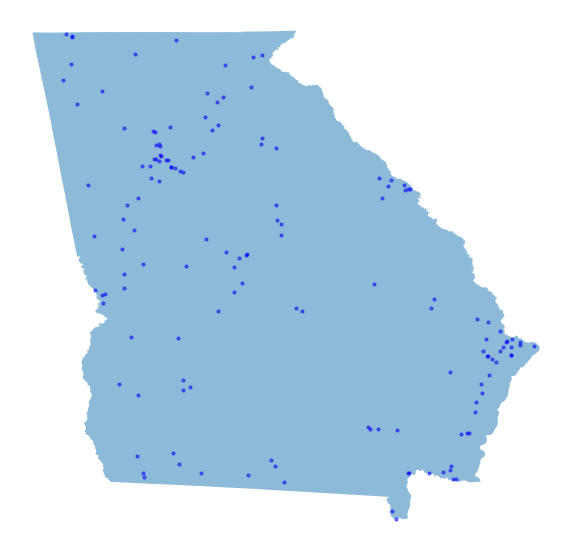

In [97]:
aa_LL.get_all_anomalies(1,1, drop_imputed = True)
print(f'There are {aa_LL.anomalies.shape[0]} anomalies with no imputed values.')

fig,ax = plt.subplots(figsize = (10,10))
GApd.plot(ax =ax, alpha = .5)
places_to_geom(aa_LL.anomalies).plot(ax = ax, markersize = 10, alpha = .5, color = 'blue')
plt.axis('off')

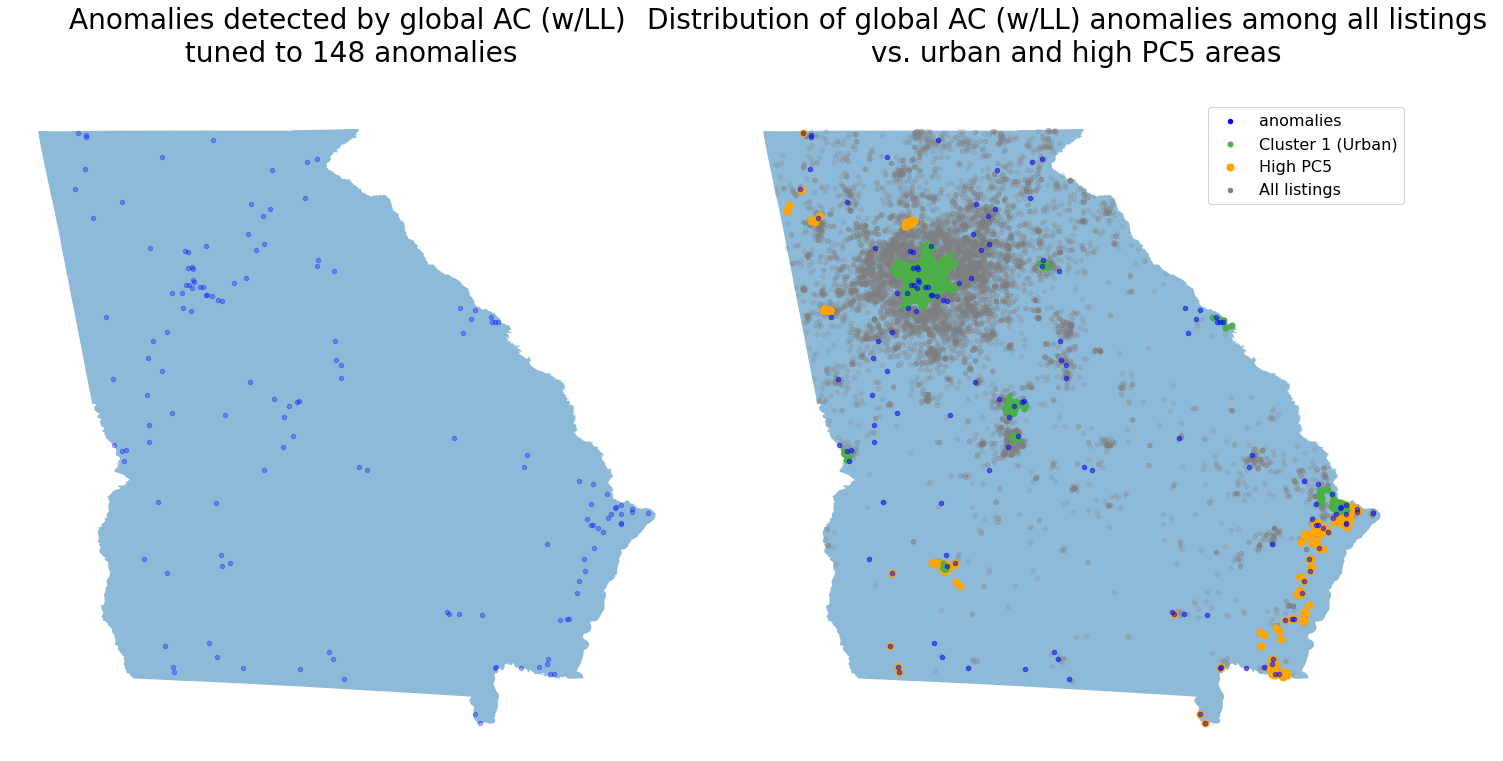

In [100]:
fig = plt.figure(figsize = (20,10))

ax1 = fig.add_subplot(121)
GApd.plot(ax =ax1, alpha = .5)
places_to_geom(aa_LL.anomalies).plot(ax = ax1, markersize = 20, color = 'blue', alpha = .3)
ax1.axis('off')
ax1.set_title('Anomalies detected by global AC (w/LL)\n tuned to 148 anomalies\n', fontsize = 28)

ax2 = fig.add_subplot(122)
plot_anomaly_comparison(aa_LL, ax2, 
                        'Distribution of global AC (w/LL) anomalies among all listings \n vs. urban and high PC5 areas\n')
fig.tight_layout(pad = 0, w_pad = 1)
fig.savefig('global_LL_anomalymap.png', dpi = 320, bbox_inches = 'tight', pad_inches = .01)

In [57]:
labeled_LL = dcb_LL.data_with_labels()
sizes_LL = dcb_LL.get_cluster_sizes()
sizes_LL

cluster_label  n_members
0               961         31
1               394         25
2               272         21
3                60         20
4               259         20
...             ...        ...
2419           2111          1
2420           1235          1
2421           1560          1
2422           1495          1
2423           1739          1

[2424 rows x 2 columns]

<AxesSubplot:>

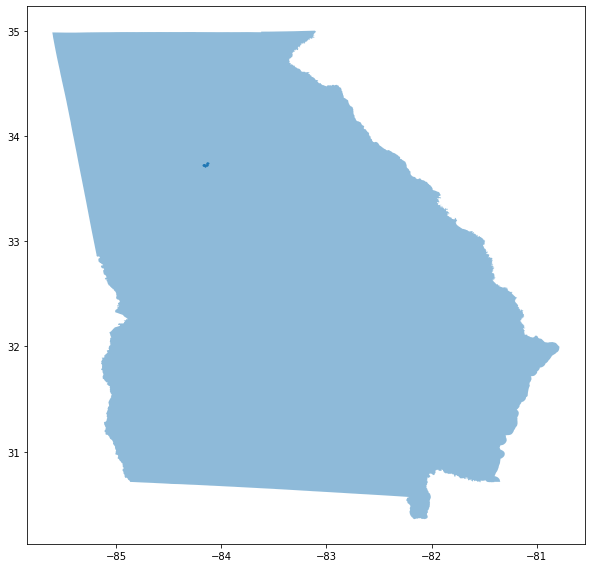

In [58]:
nth_largest = 5

fig, ax = plt.subplots(figsize = (10,10))
GApd.plot(ax = ax, alpha = .5)
places_to_geom(labeled_LL[labeled_LL['cluster'] == sizes_LL.iloc[nth_largest, 0]]).plot(ax = ax, markersize = 1)

# Only on coords

In [59]:
model_coords = AgglomerativeClustering(n_clusters = None, distance_threshold = .065)
results_coords = model_coords.fit_predict(pca_coord[['latitude', 'longitude']])
print(f'Total clusters: {np.unique(results_coords).shape[0]}')

Total clusters: 1764


In [60]:
dcb_coords = DataClusterBundle(X_5, coords, results_coords)
aa_coords = AnomalyAnalyzer(dcb_coords, features)

In [61]:
aa_coords.get_all_anomalies(1,1, drop_imputed = True)
print(f'There are {aa_coords.anomalies.shape[0]} anomalies with no imputed values.')

There are 153 anomalies with no imputed values.


In [62]:
labeled_coords = aa_coords.labeled_data
sizes_coords = dcb_coords.get_cluster_sizes()

<AxesSubplot:>

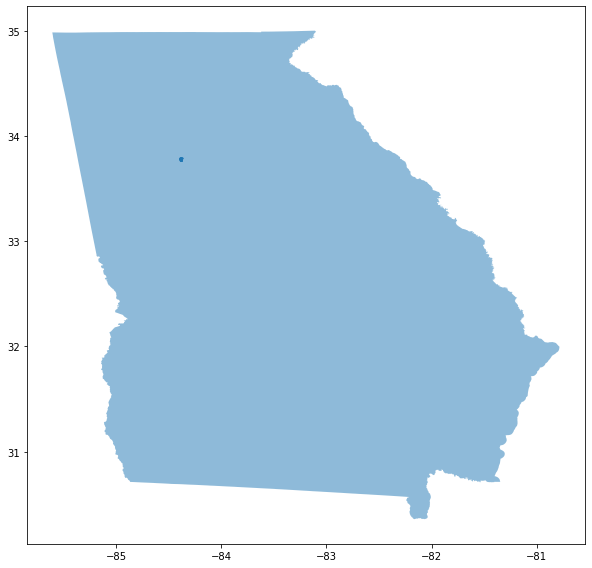

In [63]:
nth_largest = 0

fig, ax = plt.subplots(figsize = (10,10))
GApd.plot(ax = ax, alpha = .5)
places_to_geom(labeled_coords[labeled_coords['cluster']  == sizes_coords.iloc[nth_largest, 0]]).plot(ax = ax, markersize = 1)

This is the plot of clustering simply by lat long. This looks much closer to the plot w LL + features above, except for the urban center. Since these are anomalies in the first model, they are not getting combined with other groups, so they are too dissimilar. Since they are not too dissimilar in terms of location (seen below), then they must have had more variety in other features (probably higher variance of features). But, overall, the anomaly distribution makes it look very similar.

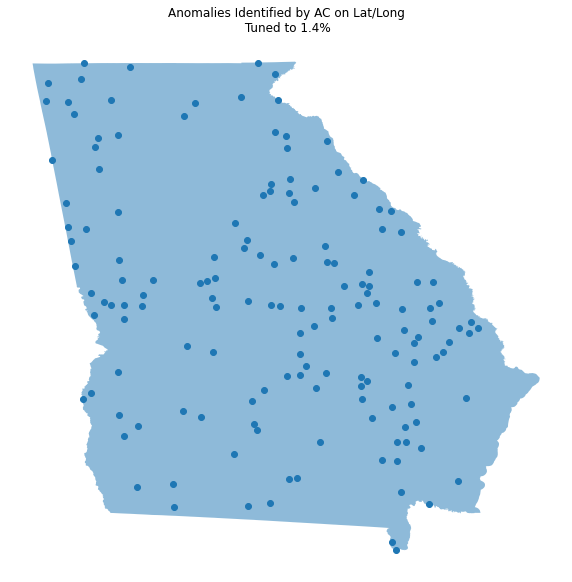

In [64]:
aa_coords.map_anomalies(GA, title = 'Anomalies Identified by AC on Lat/Long\n Tuned to 1.4%')

# Isolation Forest (noLL)

In [65]:
isoforest = IsolationForest(contamination = .015, random_state = 42)
iso_results = isoforest.fit_predict(pca_features.values)

In [66]:
dcb_iso = DataClusterBundle(X_5, coords, iso_results)
aa_iso = AnomalyAnalyzer(dcb_iso, features)
aa_iso.labeled_data.cluster.value_counts()

 1    12889
-1      197
Name: cluster, dtype: int64

In [67]:
aa_iso.get_all_anomalies(1,200, drop_imputed = True)
aa_iso.anomalies.shape[0]

151

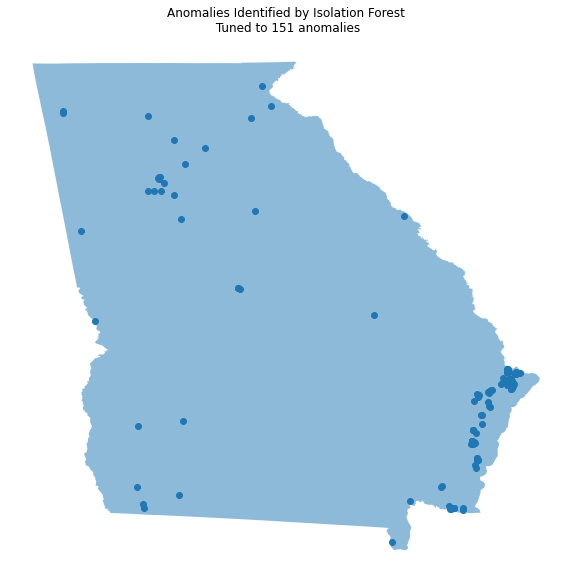

In [68]:
aa_iso.map_anomalies(GA, title = 'Anomalies Identified by Isolation Forest\n Tuned to 151 anomalies')

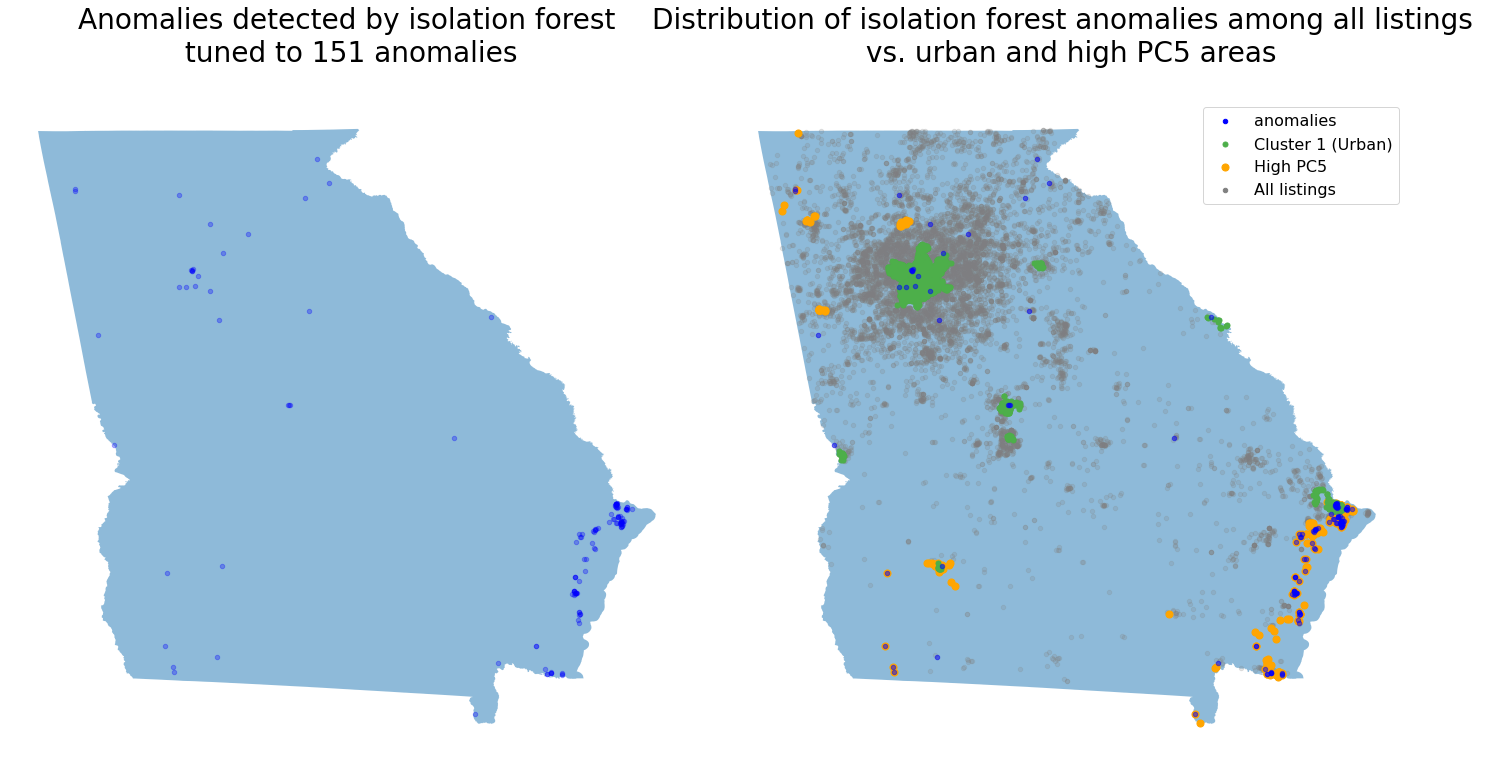

In [69]:
fig = plt.figure(figsize = (20,10))

ax1 = fig.add_subplot(121)
GApd.plot(ax =ax1, alpha = .5)
places_to_geom(aa_iso.anomalies).plot(ax = ax1, markersize = 20, color = 'blue', alpha = .3)
ax1.axis('off')
ax1.set_title('Anomalies detected by isolation forest\n tuned to 151 anomalies\n', fontsize = 28)

ax2 = fig.add_subplot(122)
plot_anomaly_comparison(aa_iso, ax2, 
                        'Distribution of isolation forest anomalies among all listings \n vs. urban and high PC5 areas\n')
fig.tight_layout(pad = 0)
fig.savefig('iso_anomaly_map.png', dpi = 320, bbox_inches = 'tight', pad_inches = .01)

## Isolation Forest (LL)

In [70]:
isoforestLL = IsolationForest(contamination = .0125, random_state = 42)
iso_resultsLL = isoforestLL.fit_predict(pca_coord.values)

In [71]:
dcb_isoLL = DataClusterBundle(X_5, coords, iso_resultsLL)
aa_isoLL = AnomalyAnalyzer(dcb_isoLL, features)
aa_isoLL.labeled_data.cluster.value_counts()

 1    12922
-1      164
Name: cluster, dtype: int64

In [72]:
aa_isoLL.get_all_anomalies(1,200, drop_imputed = True)
aa_isoLL.anomalies.shape[0]

151

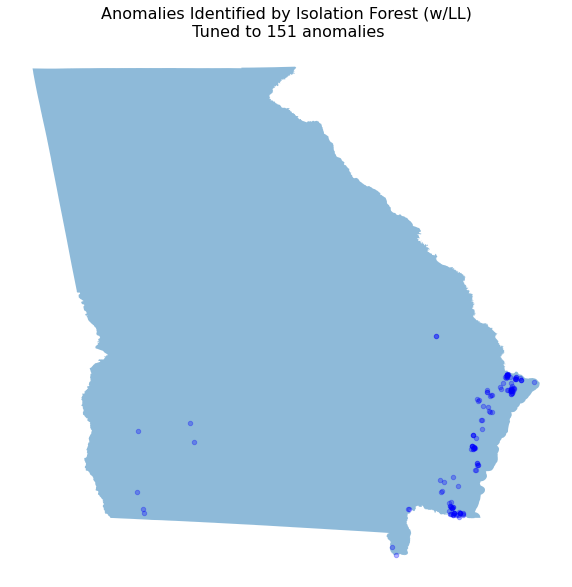

In [73]:
fig, ax = plt.subplots(figsize = (10,10))
GApd.plot(ax =ax, alpha = .5)
places_to_geom(aa_isoLL.anomalies).plot(ax = ax, markersize = 20, color = 'blue', alpha = .3)
ax.axis('off')
ax.set_title('Anomalies Identified by Isolation Forest (w/LL)\n Tuned to 151 anomalies', fontsize = 16)
fig.savefig('isoLLmap.png', dpi = 320, bbox_inches = 'tight', pad_inches = .01)

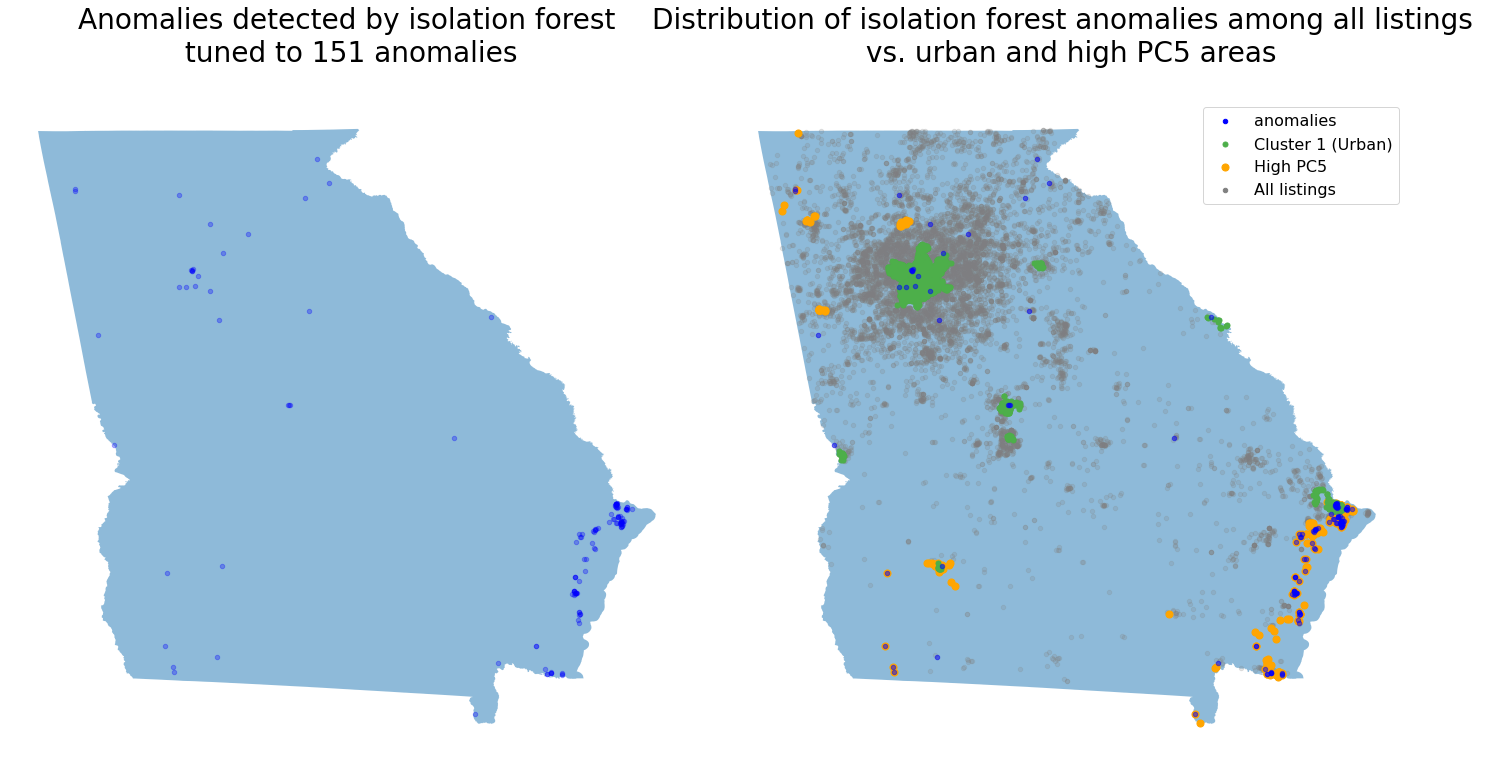

In [74]:
fig = plt.figure(figsize = (20,10))

ax1 = fig.add_subplot(121)
GApd.plot(ax =ax1, alpha = .5)
places_to_geom(aa_iso.anomalies).plot(ax = ax1, markersize = 20, color = 'blue', alpha = .3)
ax1.axis('off')
ax1.set_title('Anomalies detected by isolation forest\n tuned to 151 anomalies\n', fontsize = 28)

ax2 = fig.add_subplot(122)
plot_anomaly_comparison(aa_iso, ax2, 
                        'Distribution of isolation forest anomalies among all listings \n vs. urban and high PC5 areas\n')
fig.tight_layout(pad = 0)
fig.savefig('iso_anomaly_map.png', dpi = 320, bbox_inches = 'tight', pad_inches = .01)

# 3 tunings

## Iso forest

In [75]:
isoforest3 = IsolationForest(contamination = .0329, random_state = 42)
iso_results3 = isoforest3.fit_predict(pca_features.values)

In [76]:
dcb_iso3 = DataClusterBundle(X_5, coords, iso_results3)
aa_iso3 = AnomalyAnalyzer(dcb_iso3, features)
aa_iso3.labeled_data.cluster.value_counts()

 1    12655
-1      431
Name: cluster, dtype: int64

In [77]:
aa_iso3.get_all_anomalies(1,500, drop_imputed = True)
aa_iso3.anomalies.shape[0]

334

In [78]:
isoforest5 = IsolationForest(contamination = .053, random_state = 42)
iso_results5 = isoforest5.fit_predict(pca_features.values)

In [79]:
dcb_iso5 = DataClusterBundle(X_5, coords, iso_results5)
aa_iso5 = AnomalyAnalyzer(dcb_iso5, features)
aa_iso5.labeled_data.cluster.value_counts()

 1    12392
-1      694
Name: cluster, dtype: int64

In [80]:
aa_iso5.get_all_anomalies(1,1000, drop_imputed = True)
aa_iso5.anomalies.shape[0]

540

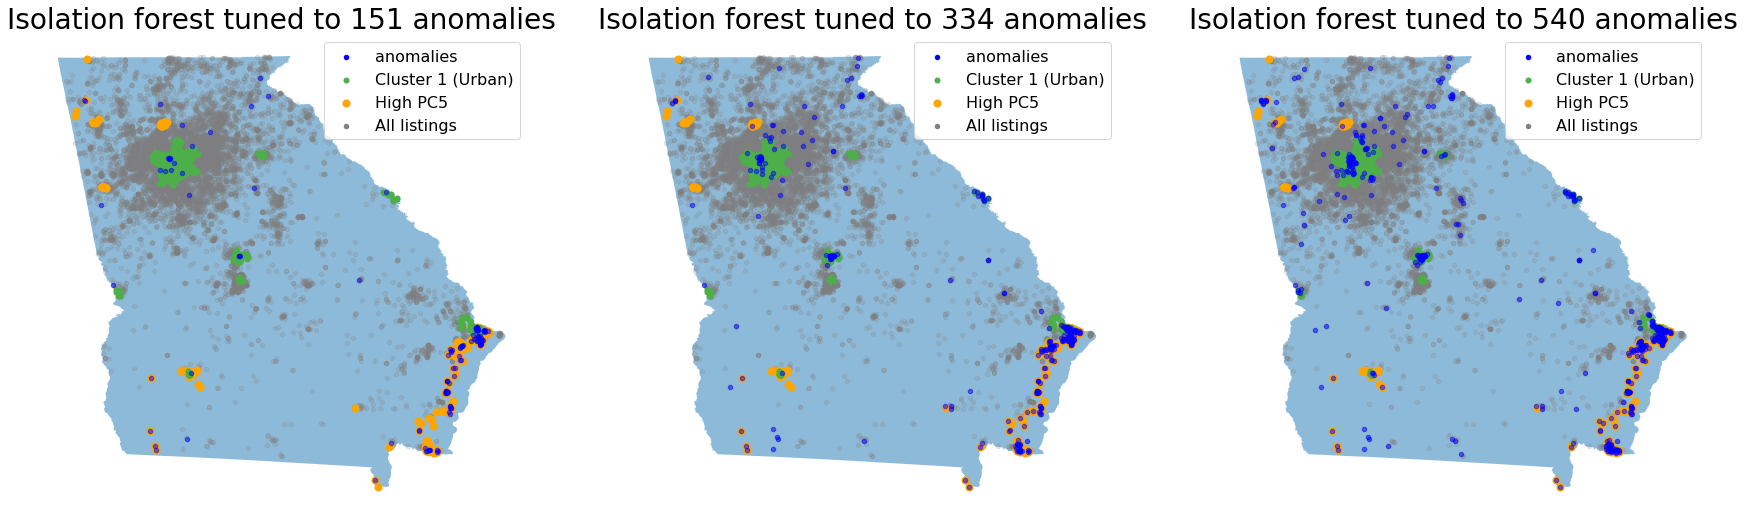

In [81]:
fig = plt.figure(figsize = (30,10))
ax1 = fig.add_subplot(131)
plot_anomaly_comparison(aa_iso, ax1, f'Isolation forest tuned to {aa_iso.anomalies.shape[0]} anomalies')
ax2 = fig.add_subplot(132)
plot_anomaly_comparison(aa_iso3, ax2, f'Isolation forest tuned to {aa_iso3.anomalies.shape[0]} anomalies')
ax3 = fig.add_subplot(133)
plot_anomaly_comparison(aa_iso5, ax3, f'Isolation forest tuned to {aa_iso5.anomalies.shape[0]} anomalies')

## AC local

In [82]:
aclocal = ClusterOverCoords(X_5, coords, AgglomerativeClustering(n_clusters = None, distance_threshold = 2.6), 
                       cover = km.Cover(n_cubes = 20, perc_overlap = .08))
aclocal.generate_clusters()
aa_aclocal = AnomalyAnalyzer(aclocal, features)

100%|█████████████████████████████████████████████| 13086/13086 [00:05<00:00, 2573.57it/s]


There are 156 anomalies with no imputed values.


(-85.84627525, -80.54184975, 30.1234797, 35.2335803)

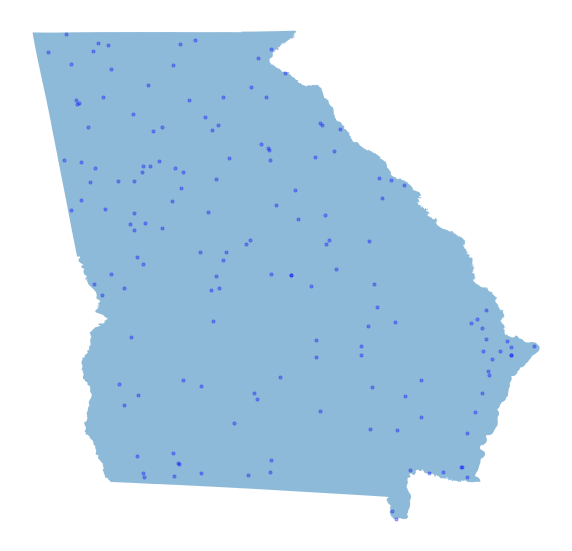

In [83]:
aa_aclocal.get_all_anomalies(1,1, drop_imputed = True)
print(f'There are {aa_aclocal.anomalies.shape[0]} anomalies with no imputed values.')

fig,ax = plt.subplots(figsize = (10,10))
GApd.plot(ax =ax, alpha = .5)
places_to_geom(aa_aclocal.anomalies).plot(ax = ax, markersize = 10, color = 'blue', alpha = .3)
plt.axis('off')

In [84]:
aclocal3 = ClusterOverCoords(X_5, coords, AgglomerativeClustering(n_clusters = None, distance_threshold = 1.85), 
                       cover = km.Cover(n_cubes = 20, perc_overlap = .08))
aclocal3.generate_clusters()
aa_aclocal3 = AnomalyAnalyzer(aclocal3, features)

100%|█████████████████████████████████████████████| 13086/13086 [00:06<00:00, 2085.16it/s]


There are 329 anomalies with no imputed values.


(-85.84627525, -80.54184975, 30.1234797, 35.2335803)

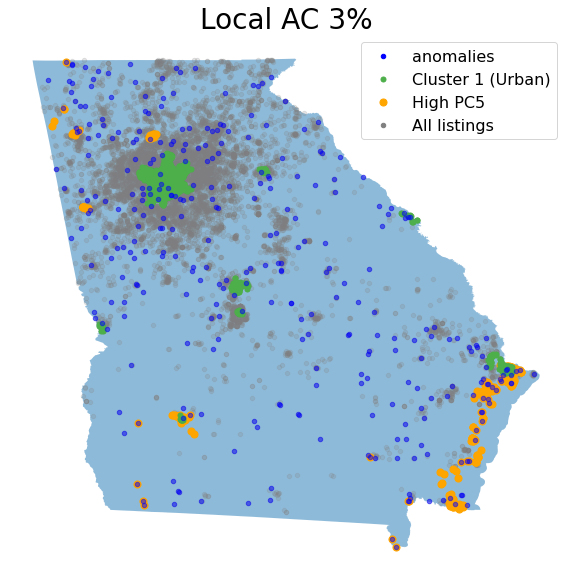

In [85]:
aa_aclocal3.get_all_anomalies(1,1, drop_imputed = True)
print(f'There are {aa_aclocal3.anomalies.shape[0]} anomalies with no imputed values.')

fig,ax = plt.subplots(figsize = (10,10))
plot_anomaly_comparison(aa_aclocal3, ax, 'Local AC 3%')
plt.axis('off')

In [86]:
aclocal5 = ClusterOverCoords(X_5, coords, AgglomerativeClustering(n_clusters = None, distance_threshold = 1.45), 
                       cover = km.Cover(n_cubes = 20, perc_overlap = .08))
aclocal5.generate_clusters()
aa_aclocal5 = AnomalyAnalyzer(aclocal5, features)

100%|█████████████████████████████████████████████| 13086/13086 [00:07<00:00, 1712.14it/s]


There are 541 anomalies with no imputed values.


(-85.84627525, -80.54184975, 30.1234797, 35.2335803)

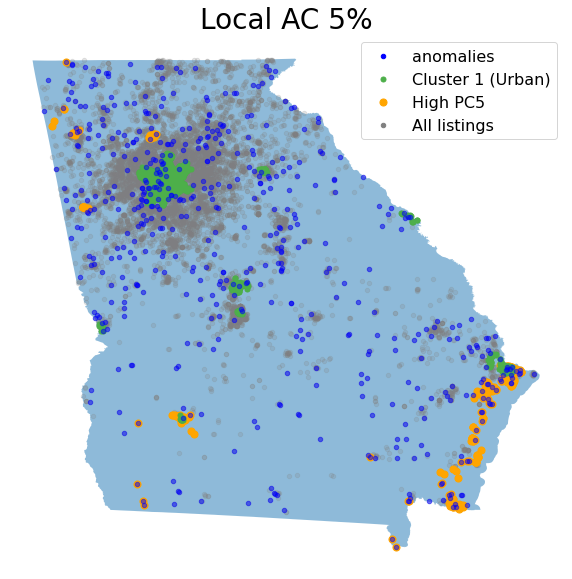

In [87]:
aa_aclocal5.get_all_anomalies(1,1, drop_imputed = True)
print(f'There are {aa_aclocal5.anomalies.shape[0]} anomalies with no imputed values.')

fig,ax = plt.subplots(figsize = (10,10))
plot_anomaly_comparison(aa_aclocal5, ax, 'Local AC 5%')
plt.axis('off')

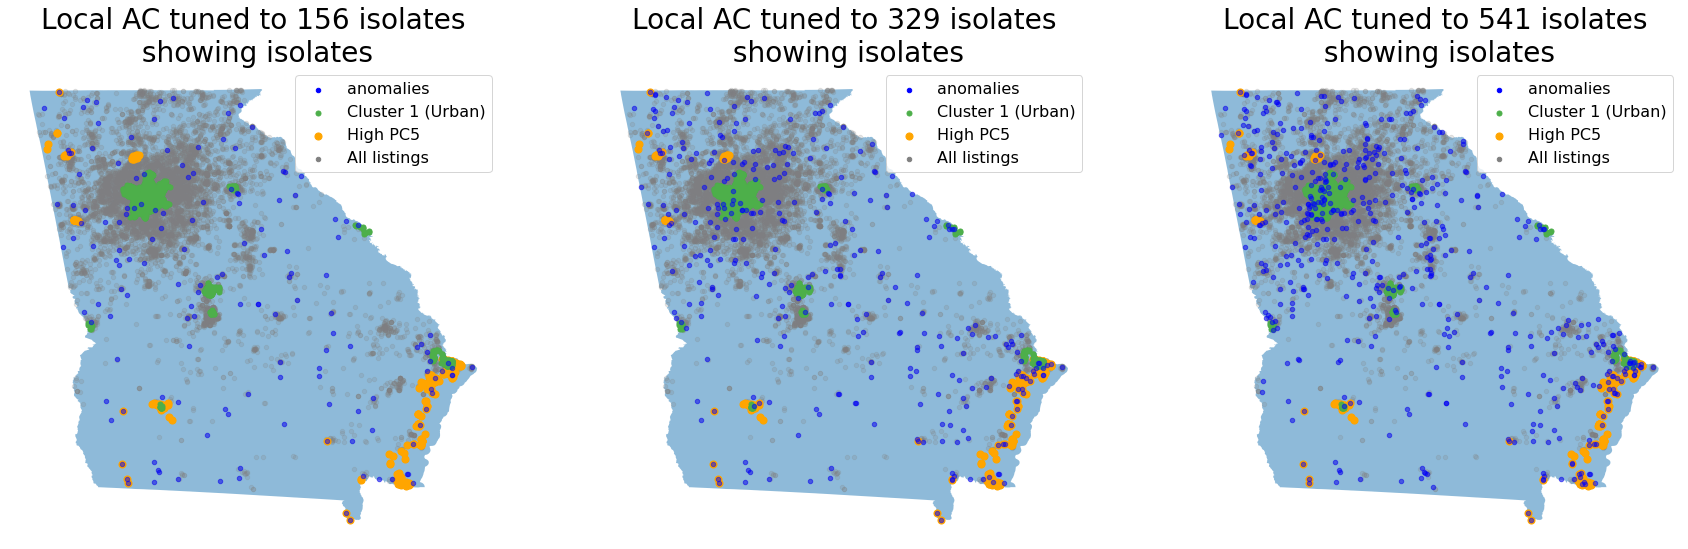

In [88]:
fig = plt.figure(figsize = (30,10))
ax1 = fig.add_subplot(131)
plot_anomaly_comparison(aa_aclocal, ax1, 
                        f'Local AC tuned to {aa_aclocal.anomalies.shape[0]} isolates\n showing isolates')
ax2 = fig.add_subplot(132)
plot_anomaly_comparison(aa_aclocal3, ax2, 
                        f'Local AC tuned to {aa_aclocal3.anomalies.shape[0]} isolates\n showing isolates')
ax3 = fig.add_subplot(133)
plot_anomaly_comparison(aa_aclocal5, ax3, 
                        f'Local AC tuned to {aa_aclocal5.anomalies.shape[0]} isolates\n showing isolates')

## AC Global

In [89]:
noLL3 = AgglomerativeClustering(n_clusters = None, distance_threshold = 1.045)
results_noLL3 = noLL3.fit_predict(X_5)
dcb_noLL3 = DataClusterBundle(X_5, coords, results_noLL3)
aa_noLL3 = AnomalyAnalyzer(dcb_noLL3, features)
aa_noLL3.get_all_anomalies(1,1, drop_imputed = True)
print(f'There are {aa_noLL3.anomalies.shape[0]} anomalies with no imputed values.')

There are 332 anomalies with no imputed values.


In [90]:
noLL5 = AgglomerativeClustering(n_clusters = None, distance_threshold = .9)
results_noLL5 = noLL5.fit_predict(X_5)
dcb_noLL5 = DataClusterBundle(X_5, coords, results_noLL5)
aa_noLL5 = AnomalyAnalyzer(dcb_noLL5, features)
aa_noLL5.get_all_anomalies(1,1, drop_imputed = True)
print(f'There are {aa_noLL5.anomalies.shape[0]} anomalies with no imputed values.')

There are 541 anomalies with no imputed values.


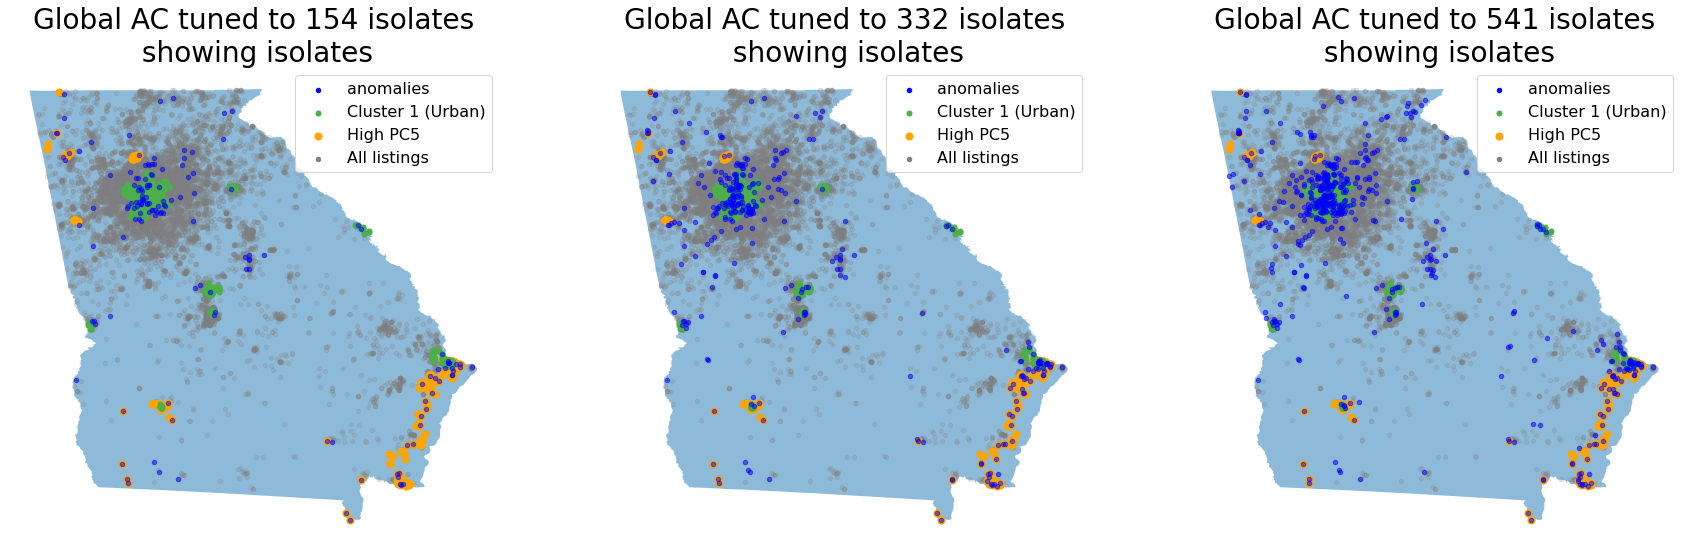

In [91]:
fig = plt.figure(figsize = (30,10))
ax1 = fig.add_subplot(131)
plot_anomaly_comparison(aa_noLL, ax1, 
                        f'Global AC tuned to {aa_noLL.anomalies.shape[0]} isolates\n showing isolates')
ax2 = fig.add_subplot(132)
plot_anomaly_comparison(aa_noLL3, ax2, 
                        f'Global AC tuned to {aa_noLL3.anomalies.shape[0]} isolates\n showing isolates')
ax3 = fig.add_subplot(133)
plot_anomaly_comparison(aa_noLL5, ax3, 
                        f'Global AC tuned to {aa_noLL5.anomalies.shape[0]} isolates\n showing isolates')

## Comparing all three models at all three tunings

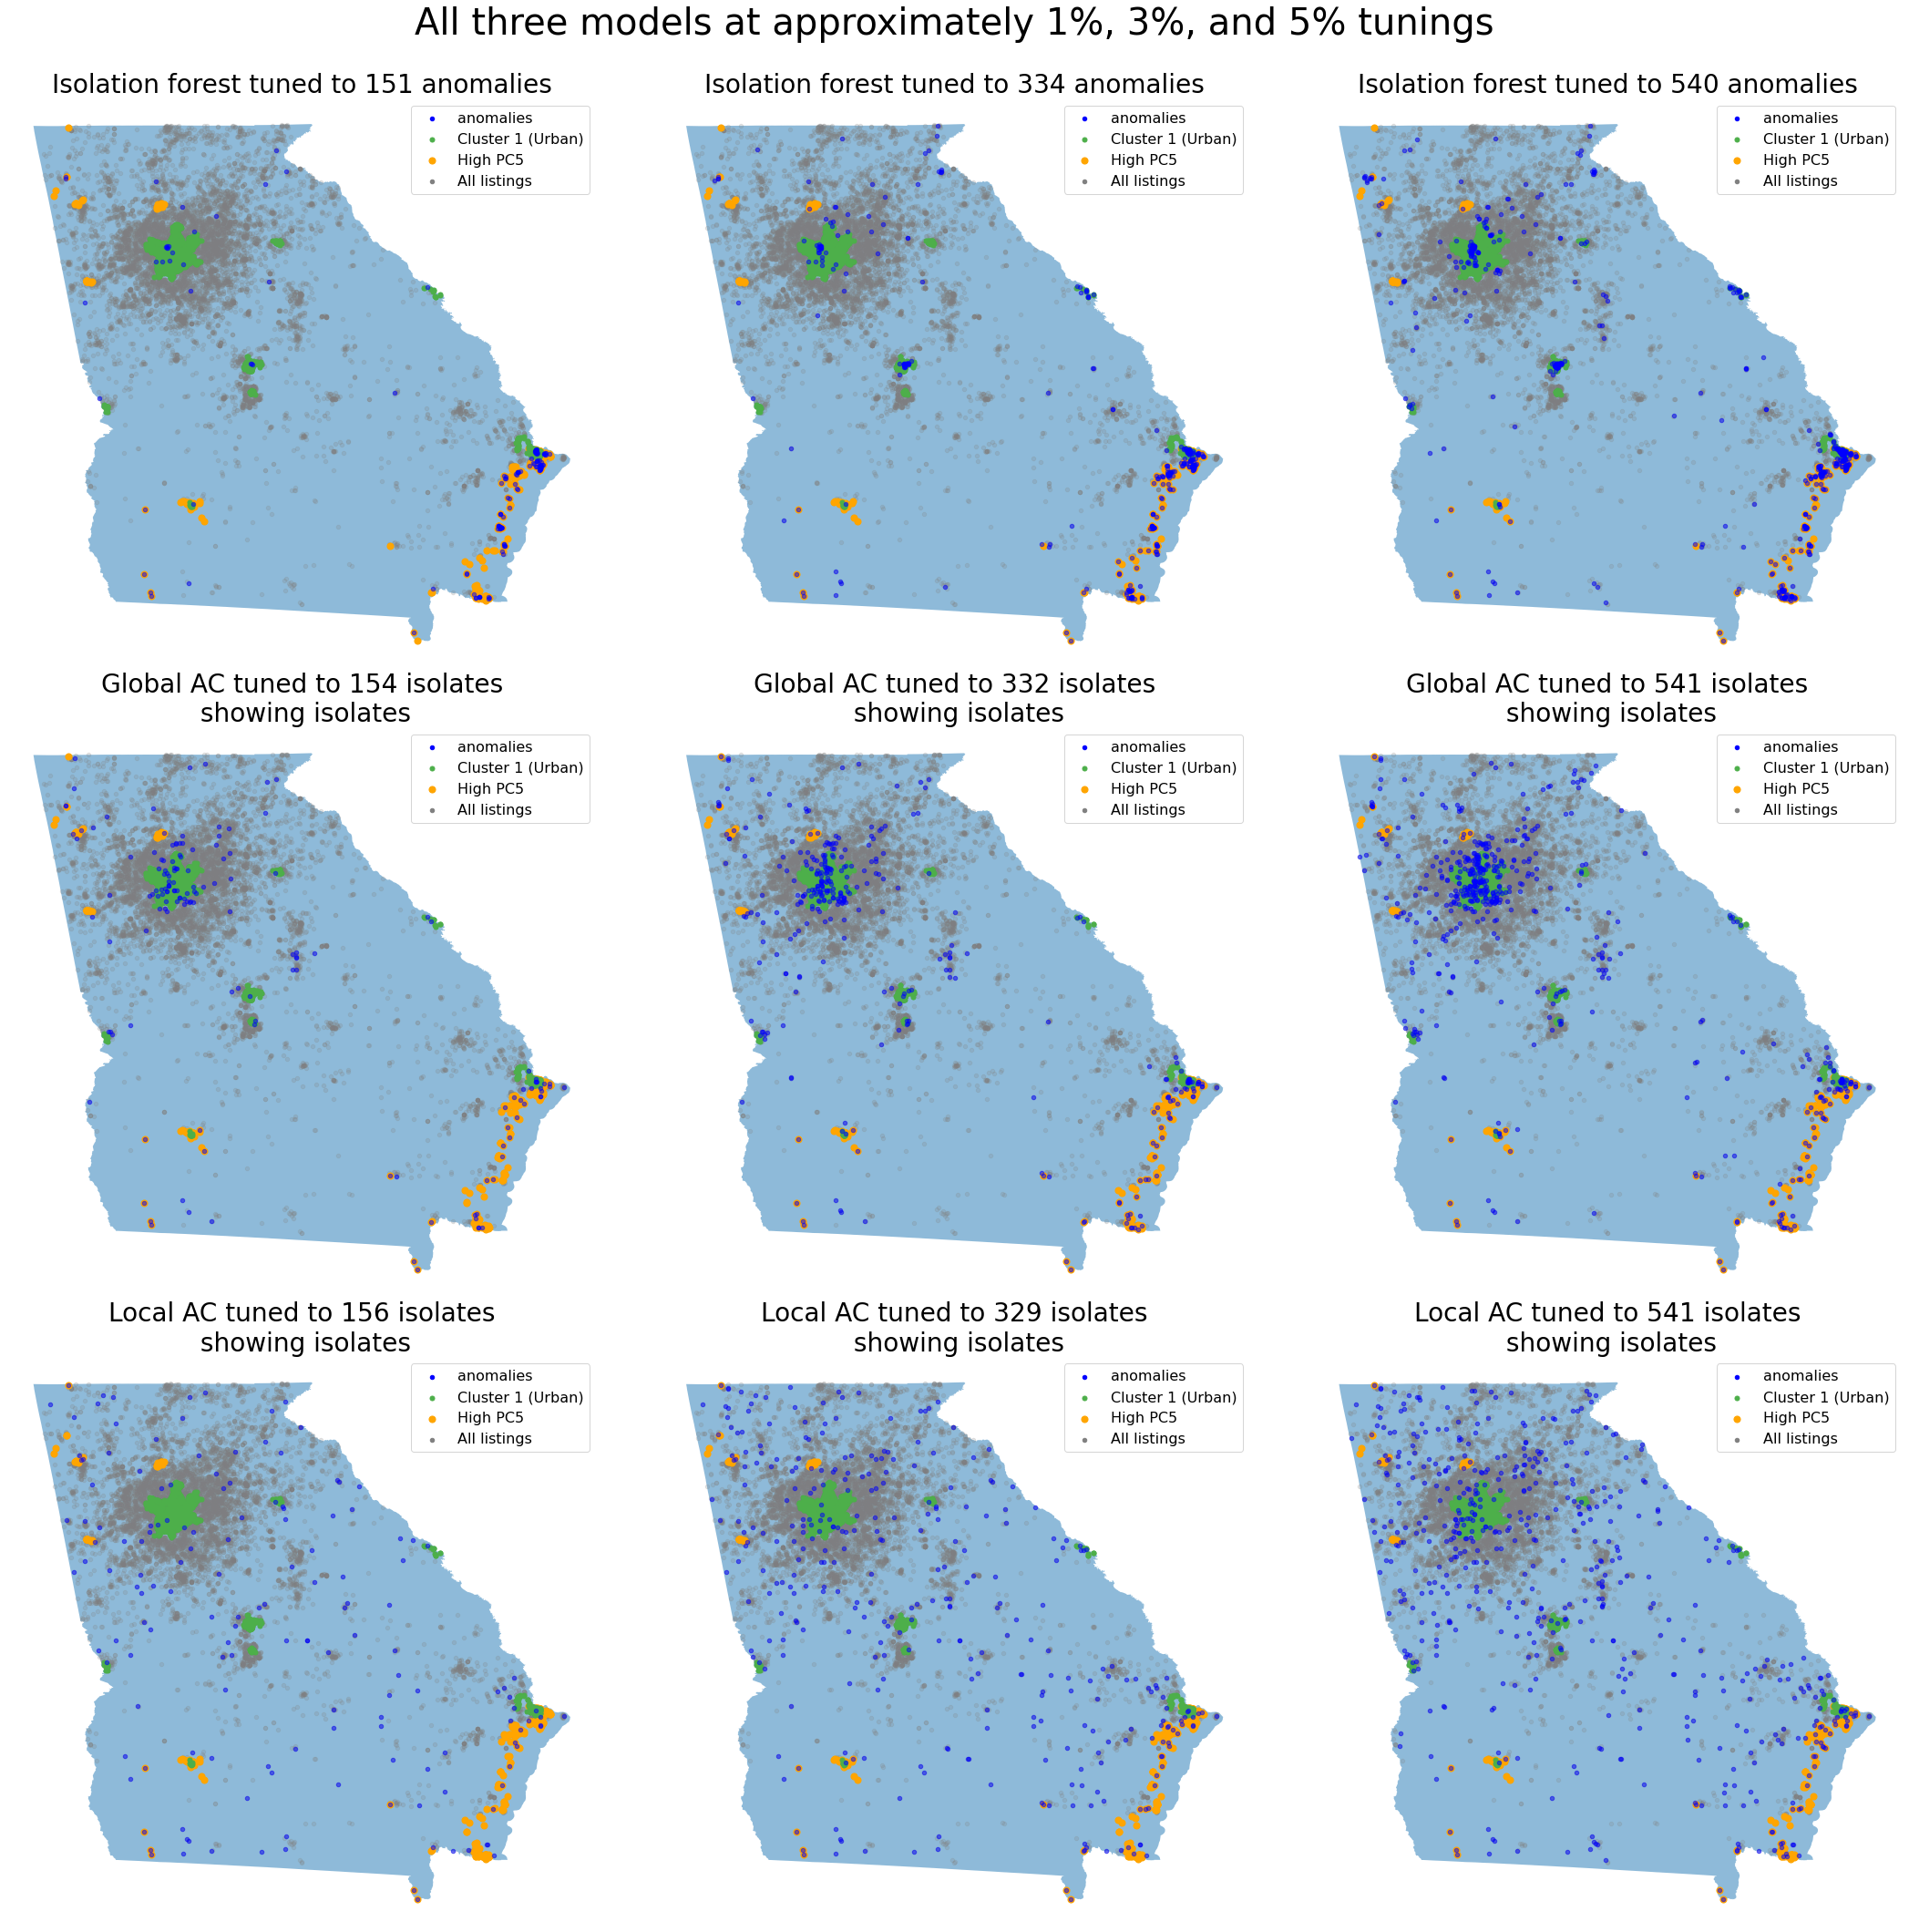

In [93]:
fig = plt.figure(figsize = (30,30))

#Iso forests
ax1 = fig.add_subplot(331)
plot_anomaly_comparison(aa_iso, ax1, f'Isolation forest tuned to {aa_iso.anomalies.shape[0]} anomalies')
ax2 = fig.add_subplot(332)
plot_anomaly_comparison(aa_iso3, ax2, f'Isolation forest tuned to {aa_iso3.anomalies.shape[0]} anomalies')
ax3 = fig.add_subplot(333)
plot_anomaly_comparison(aa_iso5, ax3, f'Isolation forest tuned to {aa_iso5.anomalies.shape[0]} anomalies')

#Global AC
ax4 = fig.add_subplot(334)
plot_anomaly_comparison(aa_noLL, ax4, 
                        f'Global AC tuned to {aa_noLL.anomalies.shape[0]} isolates\n showing isolates')
ax5 = fig.add_subplot(335)
plot_anomaly_comparison(aa_noLL3, ax5, 
                        f'Global AC tuned to {aa_noLL3.anomalies.shape[0]} isolates\n showing isolates')
ax6 = fig.add_subplot(336)
plot_anomaly_comparison(aa_noLL5, ax6, 
                        f'Global AC tuned to {aa_noLL5.anomalies.shape[0]} isolates\n showing isolates')

#Local AC
ax7 = fig.add_subplot(3,3,7)
plot_anomaly_comparison(aa_aclocal, ax7, 
                        f'Local AC tuned to {aa_aclocal.anomalies.shape[0]} isolates\n showing isolates')
ax8 = fig.add_subplot(3,3,8)
plot_anomaly_comparison(aa_aclocal3, ax8, 
                        f'Local AC tuned to {aa_aclocal3.anomalies.shape[0]} isolates\n showing isolates')
ax9 = fig.add_subplot(3,3,9)
plot_anomaly_comparison(aa_aclocal5, ax9, 
                        f'Local AC tuned to {aa_aclocal5.anomalies.shape[0]} isolates\n showing isolates')

fig.tight_layout(rect = [0,0,1,.95])
fig.suptitle('All three models at approximately 1%, 3%, and 5% tunings', fontsize = 40)
fig.savefig('3tunings.png', dpi = 320, bbox_inches = 'tight', pad_inches = .01)

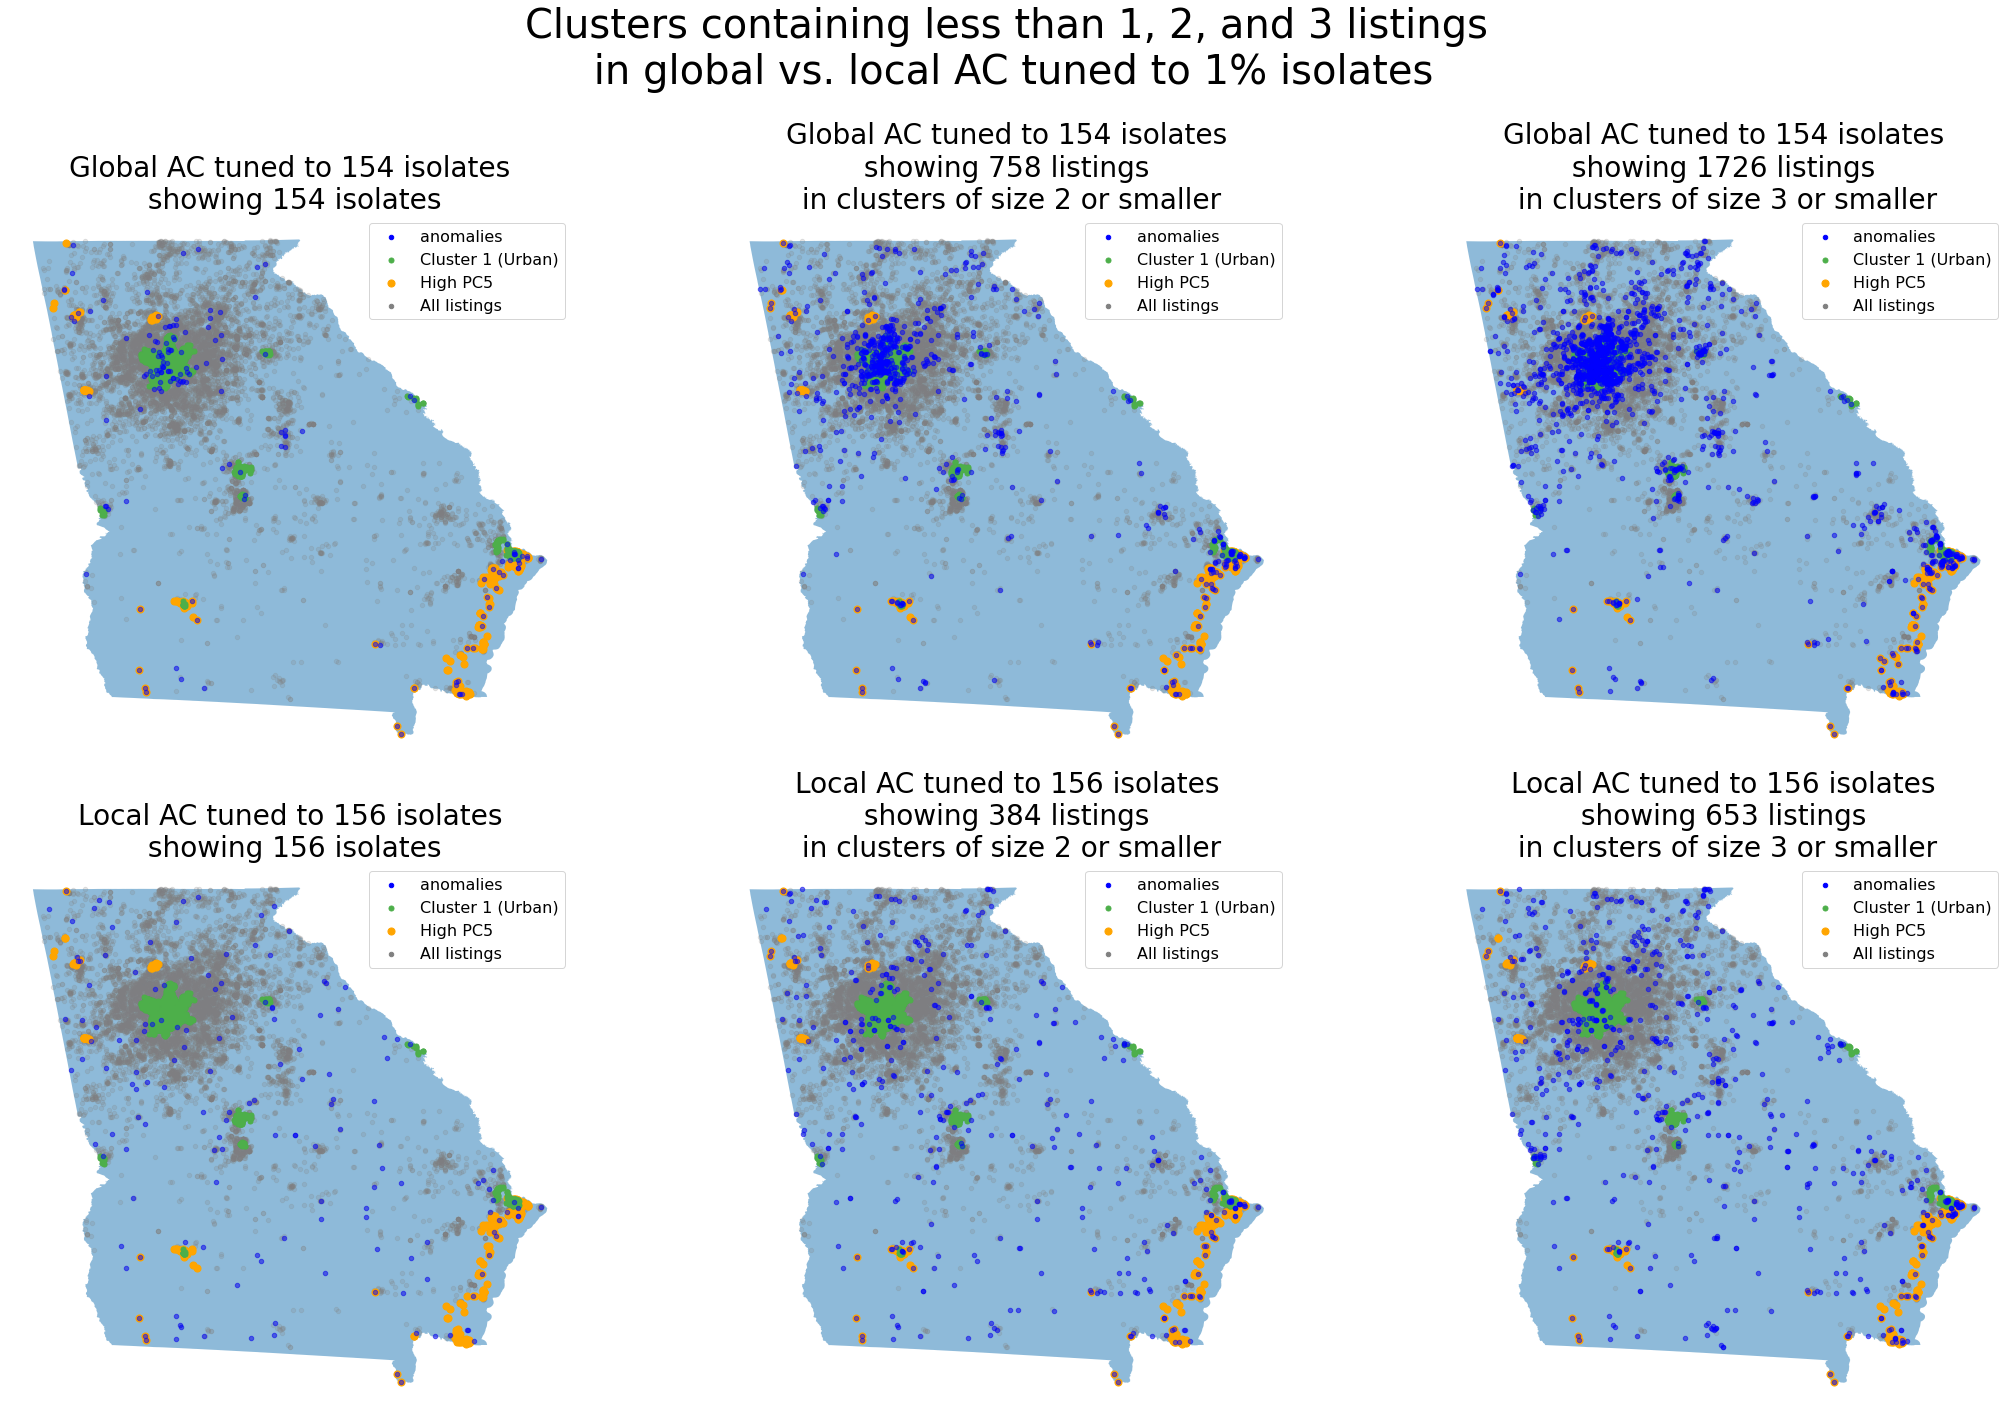

In [94]:
fig = plt.figure(figsize = (30,20))


#Global AC tuned to 1% at cutoff 1, 2, and 3
aa_noLL.get_all_anomalies(1,1, drop_imputed = True)
noLL_isolates = aa_noLL.anomalies.shape[0]
ax1 = fig.add_subplot(231)
plot_anomaly_comparison(aa_noLL, ax1, 
                        f'Global AC tuned to {noLL_isolates} isolates\n showing {noLL_isolates} isolates')
ax2 = fig.add_subplot(232)
aa_noLL.get_all_anomalies(1,2, drop_imputed = True)
plot_anomaly_comparison(aa_noLL, ax2, 
                        f'Global AC tuned to {noLL_isolates} isolates\n showing {aa_noLL.anomalies.shape[0]} listings \n in clusters of size 2 or smaller')

aa_noLL.get_all_anomalies(1,3, drop_imputed = True)
ax3 = fig.add_subplot(233)
plot_anomaly_comparison(aa_noLL, ax3, 
                        f'Global AC tuned to {noLL_isolates} isolates\n showing {aa_noLL.anomalies.shape[0]} listings \n in clusters of size 3 or smaller')

#Local AC tuned to 1% at cutoff 1, 2, and 3
aa_aclocal.get_all_anomalies(1,1, drop_imputed = True)
aclocal_isolates = aa_aclocal.anomalies.shape[0]
ax4 = fig.add_subplot(234)
plot_anomaly_comparison(aa_aclocal, ax4, 
                        f'Local AC tuned to {aclocal_isolates} isolates\n showing {aclocal_isolates} isolates')
ax5 = fig.add_subplot(235)
aa_aclocal.get_all_anomalies(1,2, drop_imputed = True)
plot_anomaly_comparison(aa_aclocal, ax5, 
                        f'Local AC tuned to {aclocal_isolates} isolates\n showing {aa_aclocal.anomalies.shape[0]} listings \n in clusters of size 2 or smaller')

aa_aclocal.get_all_anomalies(1,3, drop_imputed = True)
ax6 = fig.add_subplot(236)
plot_anomaly_comparison(aa_aclocal, ax6, 
                        f'Local AC tuned to {aclocal_isolates} isolates\n showing {aa_aclocal.anomalies.shape[0]} listings \n in clusters of size 3 or smaller')

fig.tight_layout(pad = 1, h_pad = 3, rect = [0,0,1,.9])
fig.suptitle('Clusters containing less than 1, 2, and 3 listings\n in global vs. local AC tuned to 1% isolates', fontsize = 40)
fig.savefig('123cutoff.png', dpi = 320, bbox_inches = 'tight', pad_inches = .01)